# Distillation of Robust Models via the Convex Outer Adversarial Polytope - SVHN Dataset

In this notebook, two state-of-the-art CNNs of 4 convolutional layers prior to the fully-connected part (trained on the SVHN normally and robustly using the the "Convex Outer Adversarial Polytope" described in [Provable Defenses against Adversarial Examples via the Convex Outer Adversarial Polytope](https://arxiv.org/pdf/1711.00851.pdf) by Wong and Kolter) are distillated to shallow neural networks.

The distillated models have been generated using one of the following techniques:


*   "Matching the Logits" as it is described by Ba & Caruana on [Do Deep Nets Really Need to be Deep?](https://arxiv.org/pdf/1312.6184.pdf)
*   "Ranging the Teacher’s Temperature" as it is described by Hinton, Vinyals & Dean on [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531.pdf)
*   "Adversarial Distillation" as it is described by Goldblum, Fowl, Feizi & Goldstein on [Adversarially Robust Distillation](https://arxiv.org/pdf/1905.09747.pdf)

## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install cleverhans

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat

## Define The Model Architectures

### CNN Network 

In [ ]:
def get_CNN_model():
  #CNN network for classification
  svhn_model = models.Sequential(name='CNN')
  svhn_model.add(layers.Conv2D(16, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  svhn_model.add(layers.Conv2D(16, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  svhn_model.add(layers.Conv2D(32, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='4'))
  svhn_model.add(layers.Conv2D(32, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='6'))
  svhn_model.add(Flatten(name='8'))
  svhn_model.add(layers.Dense(100, activation='relu', name='9'))
  svhn_model.add(layers.Dense(10, name='11'))
  return svhn_model

### Shallow CNN Network (S-CNN) with 1 Convolutional Layer

In [ ]:
def get_SCNN_model_layer1(channels):
  #CNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  svhn_model.add(Flatten(name='8'))
  svhn_model.add(layers.Dense(100, activation='relu', name='9'))
  svhn_model.add(layers.Dense(10, name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

### Shallow CNN Network (S-CNN) with 2 Convolutional Layers

In [ ]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #CNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels_l1, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  svhn_model.add(layers.Conv2D(channels_l2, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  svhn_model.add(Flatten(name='8'))
  svhn_model.add(layers.Dense(100, activation='relu', name='9'))
  svhn_model.add(layers.Dense(10, name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

## Load Dataset and Preprocessing

In [ ]:
# Restore the data
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

# Change for converted from PyTorch model
x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
# Restore the labels
y_labels_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_train.npy')
y_labels_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_test.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')
y_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_train.npy')
y_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_test.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_acc_test.npy')

## Training 

### CNN

In [ ]:
#Train CNN
def train_cnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_CNN_model()
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
svhn_model.summary()

In [ ]:
svhn_model = train_cnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('CNN_SVHN.h5')
print ('Model Saved')

### SCNN

In [ ]:
#Train SCNN
def train_scnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_SCNN_model_layer1(channels=2)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
#Save trained SCNN model
svhn_model = train_scnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('SCNN_SVHN.h5')
print ('Model Saved')

## Accuracy Evaluation on the Test Set

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
# Evaluate CNN
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras.h5')
score, acc = svhn_model.evaluate(x, keras.utils.to_categorical(y, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, keras.utils.to_categorical(y_labels_acc_test, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

## CNN Model Distillation - Shallow CNNs

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(svhn_model, x_train, x_test):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('11').output)
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(svhn_model, name):

  # Normal probabilities from logits before softmax activation
  logits = svhn_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  svhn_model = Model(svhn_model.input, output, name=name)
  
  return svhn_model

### Training / Evaluation and Attacks for 1 Layer

#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

#### Training

In [ ]:
# Arrays with the results
scores_1_layer = []
channels_number = []

channels_to_test = [2,16,32,64]

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(channel)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras_78.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn_extra, x_test_cnn_extra)

  svhn_model = get_SCNN_model_layer1(channels=channel)
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SCNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_logits, x_test_cnn_extra, test_logits)

  # Learning Curves
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer1(channels=channel)
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_1_layer.append(score)
  channels_number.append(channel)

  print ('----------------------------')

#### Results

##### Learning Curves for Extra Data - Baseline


In [ ]:
loss_train_2=[8.214879302105157, 4.782624569497268, 4.25533140754039, 4.02586806552828, 3.88925956976339, 3.7972301271826185, 3.7289598565445203, 3.676403645783393, 3.631927953604854, 3.5983096047274428, 3.5654234183478106, 3.5402537233206037, 3.5204836377592446, 3.4987871388590195, 3.4820574583897823, 3.4664069444506156, 3.452897161324463, 3.4389038060126365, 3.429153120183533, 3.417941605349215, 3.4077591664295577, 3.396586499450198, 3.3897176342404802, 3.381675032444599, 3.3731503186954797, 3.367988997231322, 3.3597199345627953, 3.3528995033424898]
loss_test_2=[5.2319467180500885, 4.414755063985823, 4.149840095661364, 3.9374119126001186, 3.883408325418983, 3.8028327419356382, 3.7023129360064453, 3.687338903380386, 3.6776345477356953, 3.62438661591576, 3.6327121534766524, 3.5865101163117314, 3.5894050909019897, 3.5645525149380113, 3.5102161080879872, 3.5271058068328465, 3.5506720387571034, 3.4807992483382315, 3.449144203761829, 3.473580511659938, 3.4624525968638413, 3.493304662853857, 3.4612359805884, 3.4442395079546286, 3.457956457768296, 3.404235415835877, 3.388950672700171, 3.3893714938747803]
acc_train_2=[0.67119867, 0.82524526, 0.84542394, 0.85544026, 0.8609427, 0.8645906, 0.8665769, 0.8687798, 0.8696176, 0.87098026, 0.871884, 0.87233585, 0.8729784, 0.8735008, 0.8739621, 0.8743034, 0.87417865, 0.8748611, 0.87544954, 0.8751859, 0.8755178, 0.87563074, 0.87583315, 0.87591785, 0.875972, 0.87606615, 0.87591785, 0.87648267]
acc_test_2=[0.8077512979507446, 0.8388827443122864, 0.8512242436408997, 0.855742871761322, 0.8593389391899109, 0.8591036200523376, 0.8646483421325684, 0.8694964647293091, 0.8660227656364441, 0.8689598441123962, 0.8673501014709473, 0.8691763877868652, 0.8692705035209656, 0.8718310594558716, 0.87037193775177, 0.8683291673660278, 0.8698918223381042, 0.874739944934845, 0.8708708882331848, 0.8734596371650696, 0.8724712133407593, 0.8722453117370605, 0.8709461688995361, 0.8740997910499573, 0.872019350528717, 0.8742504119873047, 0.8723582625389099, 0.8743069171905518]

loss_train_16=[6.066587164224562, 2.826455303404948, 2.4917331456693663, 2.343304569660667, 2.252748957225788, 2.1880424646540924, 2.1269241383453994, 2.081477465387716, 2.039639026415318, 2.0098711760602113, 1.985338603348427, 1.965429649910907, 1.9426273602855595, 1.9295066415252458, 1.9150248876574205, 1.9025362218898432, 1.8922725762590669, 1.8820056063291293, 1.874674693007808, 1.8669790141882752, 1.8578751096435842, 1.8523249250080205, 1.8452981225139726, 1.839490426117961, 1.8342492791346905, 1.8287615556914252, 1.8229972271335424, 1.8199426569913613, 1.814587736882548, 1.80957330590714, 1.8057329112076206, 1.8018487015156193, 1.7996125713437126, 1.795542098096289, 1.7931963722098898, 1.788324874932299, 1.7859410131406095, 1.784126620135732, 1.7810970234048995, 1.7783344499613223, 1.7761088886592806, 1.7722703198843621, 1.770880833689841, 1.767519399078493, 1.7659717686280039, 1.7637031090413746]
loss_test_16=[3.1833248714347295, 2.613036152367712, 2.434981009439625, 2.3421566568055727, 2.2715866841836005, 2.2077443036327704, 2.141075061931657, 2.1137359968487686, 2.0942016864097432, 2.0794814844393708, 2.0912627989953574, 2.052308039027491, 2.0337075423019155, 2.0254397271152533, 2.0067674822901442, 1.9875840989888016, 2.0060331662973994, 2.0146265716925846, 1.9855208233685782, 1.97818093934275, 1.9869703301977002, 1.9578311276253828, 1.9552896600500511, 1.9915628002858965, 1.9779012833170657, 1.9639788002837075, 1.9827401671674942, 2.016745563921473, 1.9625494823653589, 1.9427435012442187, 1.9751378065597531, 1.9329204485147913, 1.9420683754956394, 1.9468692293876533, 1.9403781340031032, 1.9201430793871357, 1.9458797536735313, 1.9547681067497071, 1.921168807196431, 1.9304641065630124, 1.9457411696205726, 1.9189890681167159, 1.9355386198237508, 1.9174553606501117, 1.936915005373468, 1.927399844387658]
acc_train_16=[0.7624687, 0.8908036, 0.8992996, 0.9035147, 0.9058658, 0.9077133, 0.90943366, 0.91054213, 0.9116106, 0.91230255, 0.91281796, 0.91342986, 0.91399705, 0.9145054, 0.9148961, 0.9151785, 0.9151455, 0.91535264, 0.9157739, 0.9156209, 0.9159434, 0.91673887, 0.9167812, 0.9167318, 0.91675764, 0.9168824, 0.91676, 0.91738135, 0.91722363, 0.9172825, 0.91725427, 0.9177461, 0.917652, 0.91760254, 0.9176614, 0.91781205, 0.9179156, 0.9180309, 0.91814387, 0.9180968, 0.9182733, 0.91831094, 0.9185369, 0.9186193, 0.9183745, 0.91842395]
acc_test_16=[0.8784301280975342, 0.8952714204788208, 0.8991875648498535, 0.901239812374115, 0.9038850665092468, 0.9056172370910645, 0.9063138365745544, 0.9069634079933167, 0.9085260629653931, 0.9086955189704895, 0.9090626835823059, 0.9095521569252014, 0.9094297885894775, 0.9100134372711182, 0.9092791676521301, 0.9103429317474365, 0.9097498655319214, 0.9104841351509094, 0.9106065034866333, 0.9108512997627258, 0.9117079377174377, 0.9118303060531616, 0.9122257232666016, 0.9123198390007019, 0.9116985201835632, 0.912216305732727, 0.911444365978241, 0.9102299809455872, 0.9117832779884338, 0.912376344203949, 0.9112937450408936, 0.9126116633415222, 0.9127999544143677, 0.9111054539680481, 0.9132235646247864, 0.9140613675117493, 0.9135624766349792, 0.9122727513313293, 0.9116796851158142, 0.9127340316772461, 0.9126304984092712, 0.9128093719482422, 0.9119903445243835, 0.9128093719482422, 0.9128376245498657, 0.9132612347602844]

loss_train_32=[5.4295184065033215, 2.760627135015236, 2.498850179293594, 2.3624656560148827, 2.2791042041309924, 2.2142763428203875, 2.1633859631472654, 2.1239548301601614, 2.093340485209053, 2.0623555312241875, 2.040254151646294, 2.0159694669188903, 1.9987736438772552, 1.9823650532849006, 1.9679820311259593, 1.9539300698740052, 1.940550404889298, 1.9294520449162993, 1.9176962714619632, 1.9079197515660367, 1.8962636729866653, 1.8898142099138093, 1.8816802289982268, 1.8736903614885012, 1.8647570204430006, 1.8584537385509403, 1.8514459850159088, 1.8475505672985097, 1.8398250799798723, 1.83427127754785, 1.8305166069211072, 1.8245110480716644, 1.8199685638568075]
loss_test_32=[2.9796691620401616, 2.6939114018282537, 2.449425315381564, 2.3688332786461483, 2.2871127799347613, 2.26338169497462, 2.1932300577004162, 2.169214875845077, 2.147765263879572, 2.1223823069309646, 2.1877107280949466, 2.079513517708282, 2.095615101037681, 2.0890649146518463, 2.0589946121535982, 2.069240162173217, 2.079513812712192, 2.0412299363403297, 2.0186580684382607, 2.0280641907808548, 2.044047347534891, 2.0055500255424716, 2.010200123501121, 1.9921016745758233, 2.013270737172605, 2.024836364428669, 1.9857250635579515, 2.00013186537893, 2.0012921335990588, 1.9947684574584161, 2.0040439797517, 2.0160109477996717, 1.9844875053108977]
acc_train_32=[0.7883145, 0.8926911, 0.9002245, 0.9039501, 0.9057834, 0.9074944, 0.90875113, 0.9097255, 0.9108999, 0.9117189, 0.9119142, 0.9129239, 0.9137288, 0.91361576, 0.9142583, 0.91465366, 0.91502315, 0.9153291, 0.9156656, 0.91553384, 0.91615516, 0.9165176, 0.9165082, 0.9171154, 0.9171178, 0.91743547, 0.9178426, 0.9173437, 0.9177367, 0.9181721, 0.9180638, 0.9182451, 0.91842395]
acc_test_32=[0.886610746383667, 0.8936710953712463, 0.8998371362686157, 0.9020023345947266, 0.9027460217475891, 0.9036967754364014, 0.9067939519882202, 0.9066433310508728, 0.9079424142837524, 0.9092133045196533, 0.9084884524345398, 0.9089590907096863, 0.9094486236572266, 0.9087990522384644, 0.9104935526847839, 0.9099758267402649, 0.9078482985496521, 0.9109359979629517, 0.9117173552513123, 0.9100511074066162, 0.9104465246200562, 0.9106159210205078, 0.9127434492111206, 0.9115573167800903, 0.911284327507019, 0.9113502502441406, 0.9120374321937561, 0.9114161133766174, 0.9103994369506836, 0.9121692180633545, 0.9110866189002991, 0.9110866189002991, 0.9116326570510864]

loss_train_64=[4.682382979695647, 2.564733007875179, 2.3098587465863525, 2.174041466077055, 2.0860363603964713, 2.0145684239232, 1.963937014319471, 1.9202530898805092, 1.887491433677417, 1.8517384898370115, 1.8279187754771509, 1.8010506934335688, 1.7826422130354778, 1.7615331353656973, 1.7440843763773934, 1.7275334812392558, 1.71358456180116, 1.6978736218642478, 1.6855728764688684, 1.6733600723766557, 1.6634257031001487, 1.6523373257745098, 1.6398983358059762, 1.632671630120162, 1.6218299083398366, 1.6121706530709043, 1.6055819119335695, 1.5961996198627457, 1.5898338560868344, 1.5816182553719902, 1.5746329367635497, 1.5686727135393257, 1.5593916160557173, 1.5548097834316776, 1.5504876255120474, 1.5444278644500504, 1.5400785218476867, 1.5334159562353105, 1.529427224061329, 1.525352192630254, 1.5195147363543386, 1.5140382108095283, 1.5097842512107753, 1.5081603508709518, 1.5047674370887552, 1.4974529322607741, 1.4949519280118049, 1.4900210240698246, 1.4879717306400997, 1.4825174148096245, 1.480548466914833, 1.4770315503696132]
loss_test_64=[2.819161336973893, 2.4245738202116693, 2.3022048286015964, 2.1928542719408304, 2.115772621408549, 2.0862414238183065, 2.021900771095751, 2.003931116557069, 1.9906805226458688, 1.9728148218598478, 1.9522191532928943, 1.916604292417756, 1.9244979636745716, 1.91911456569601, 1.8766332401949608, 1.9221404841849197, 1.882785044889861, 1.8644261662784336, 1.8881241793775119, 1.88219784266893, 1.8481144779873837, 1.8610053788342256, 1.8568956421635543, 1.8688238052036366, 1.8392634702603923, 1.829721806055564, 1.8441572507882356, 1.863947234630284, 1.8182186440935277, 1.8542062267127342, 1.8649433726418345, 1.8231857853776015, 1.814088613879214, 1.8288921766073654, 1.8341965366240514, 1.8342595010165708, 1.8396544970489022, 1.8072375059475694, 1.8032396695075357, 1.8277652423377115, 1.8288679155592418, 1.8008735912515246, 1.8323606883163055, 1.8418497223138857, 1.8308063375392905, 1.8049928164450022, 1.8381616579600535, 1.8136003896791417, 1.8962896370132059, 1.8145719972778518, 1.8173465777239355, 1.8537018386837374]
acc_train_64=[0.8228141, 0.9001798, 0.9071343, 0.910641, 0.9128462, 0.91455483, 0.9155315, 0.91664, 0.9173272, 0.91788733, 0.9182968, 0.91911113, 0.91948533, 0.92023844, 0.9204291, 0.9211751, 0.9211516, 0.921973, 0.92155874, 0.9218388, 0.92246485, 0.9228508, 0.9231944, 0.92330974, 0.923345, 0.92401105, 0.9238134, 0.92421347, 0.9244959, 0.9246159, 0.92448175, 0.9247053, 0.9251078, 0.9250372, 0.9253031, 0.9254655, 0.9260633, 0.925642, 0.92572206, 0.92584914, 0.92604446, 0.92630804, 0.9263363, 0.9263387, 0.9263316, 0.92664224, 0.92640924, 0.9266352, 0.9268541, 0.926727, 0.9267176, 0.92721415]
acc_test_64=[0.8925979137420654, 0.9032167196273804, 0.9054760336875916, 0.9075847268104553, 0.9118114709854126, 0.9091473817825317, 0.9124610424041748, 0.9130070805549622, 0.9119150638580322, 0.9136189222335815, 0.9142119884490967, 0.914701521396637, 0.9160006642341614, 0.9151910543441772, 0.9167255163192749, 0.9163019061088562, 0.9152945876121521, 0.9155675768852234, 0.9144002795219421, 0.9140802025794983, 0.9170267581939697, 0.9164525270462036, 0.9170267581939697, 0.9157464504241943, 0.9173280000686646, 0.9168384671211243, 0.917478621006012, 0.9171302914619446, 0.9175350666046143, 0.9157747030258179, 0.9167443513870239, 0.9177421927452087, 0.9177704453468323, 0.9174597859382629, 0.9183164238929749, 0.9168478846549988, 0.9176951050758362, 0.9170455932617188, 0.9180999398231506, 0.9175256490707397, 0.9166595935821533, 0.9185799956321716, 0.9176856875419617, 0.9172244071960449, 0.9182411432266235, 0.9183635115623474, 0.9179493188858032, 0.9181563854217529, 0.916405439376831, 0.9173468351364136, 0.9185423851013184, 0.9180716872215271]

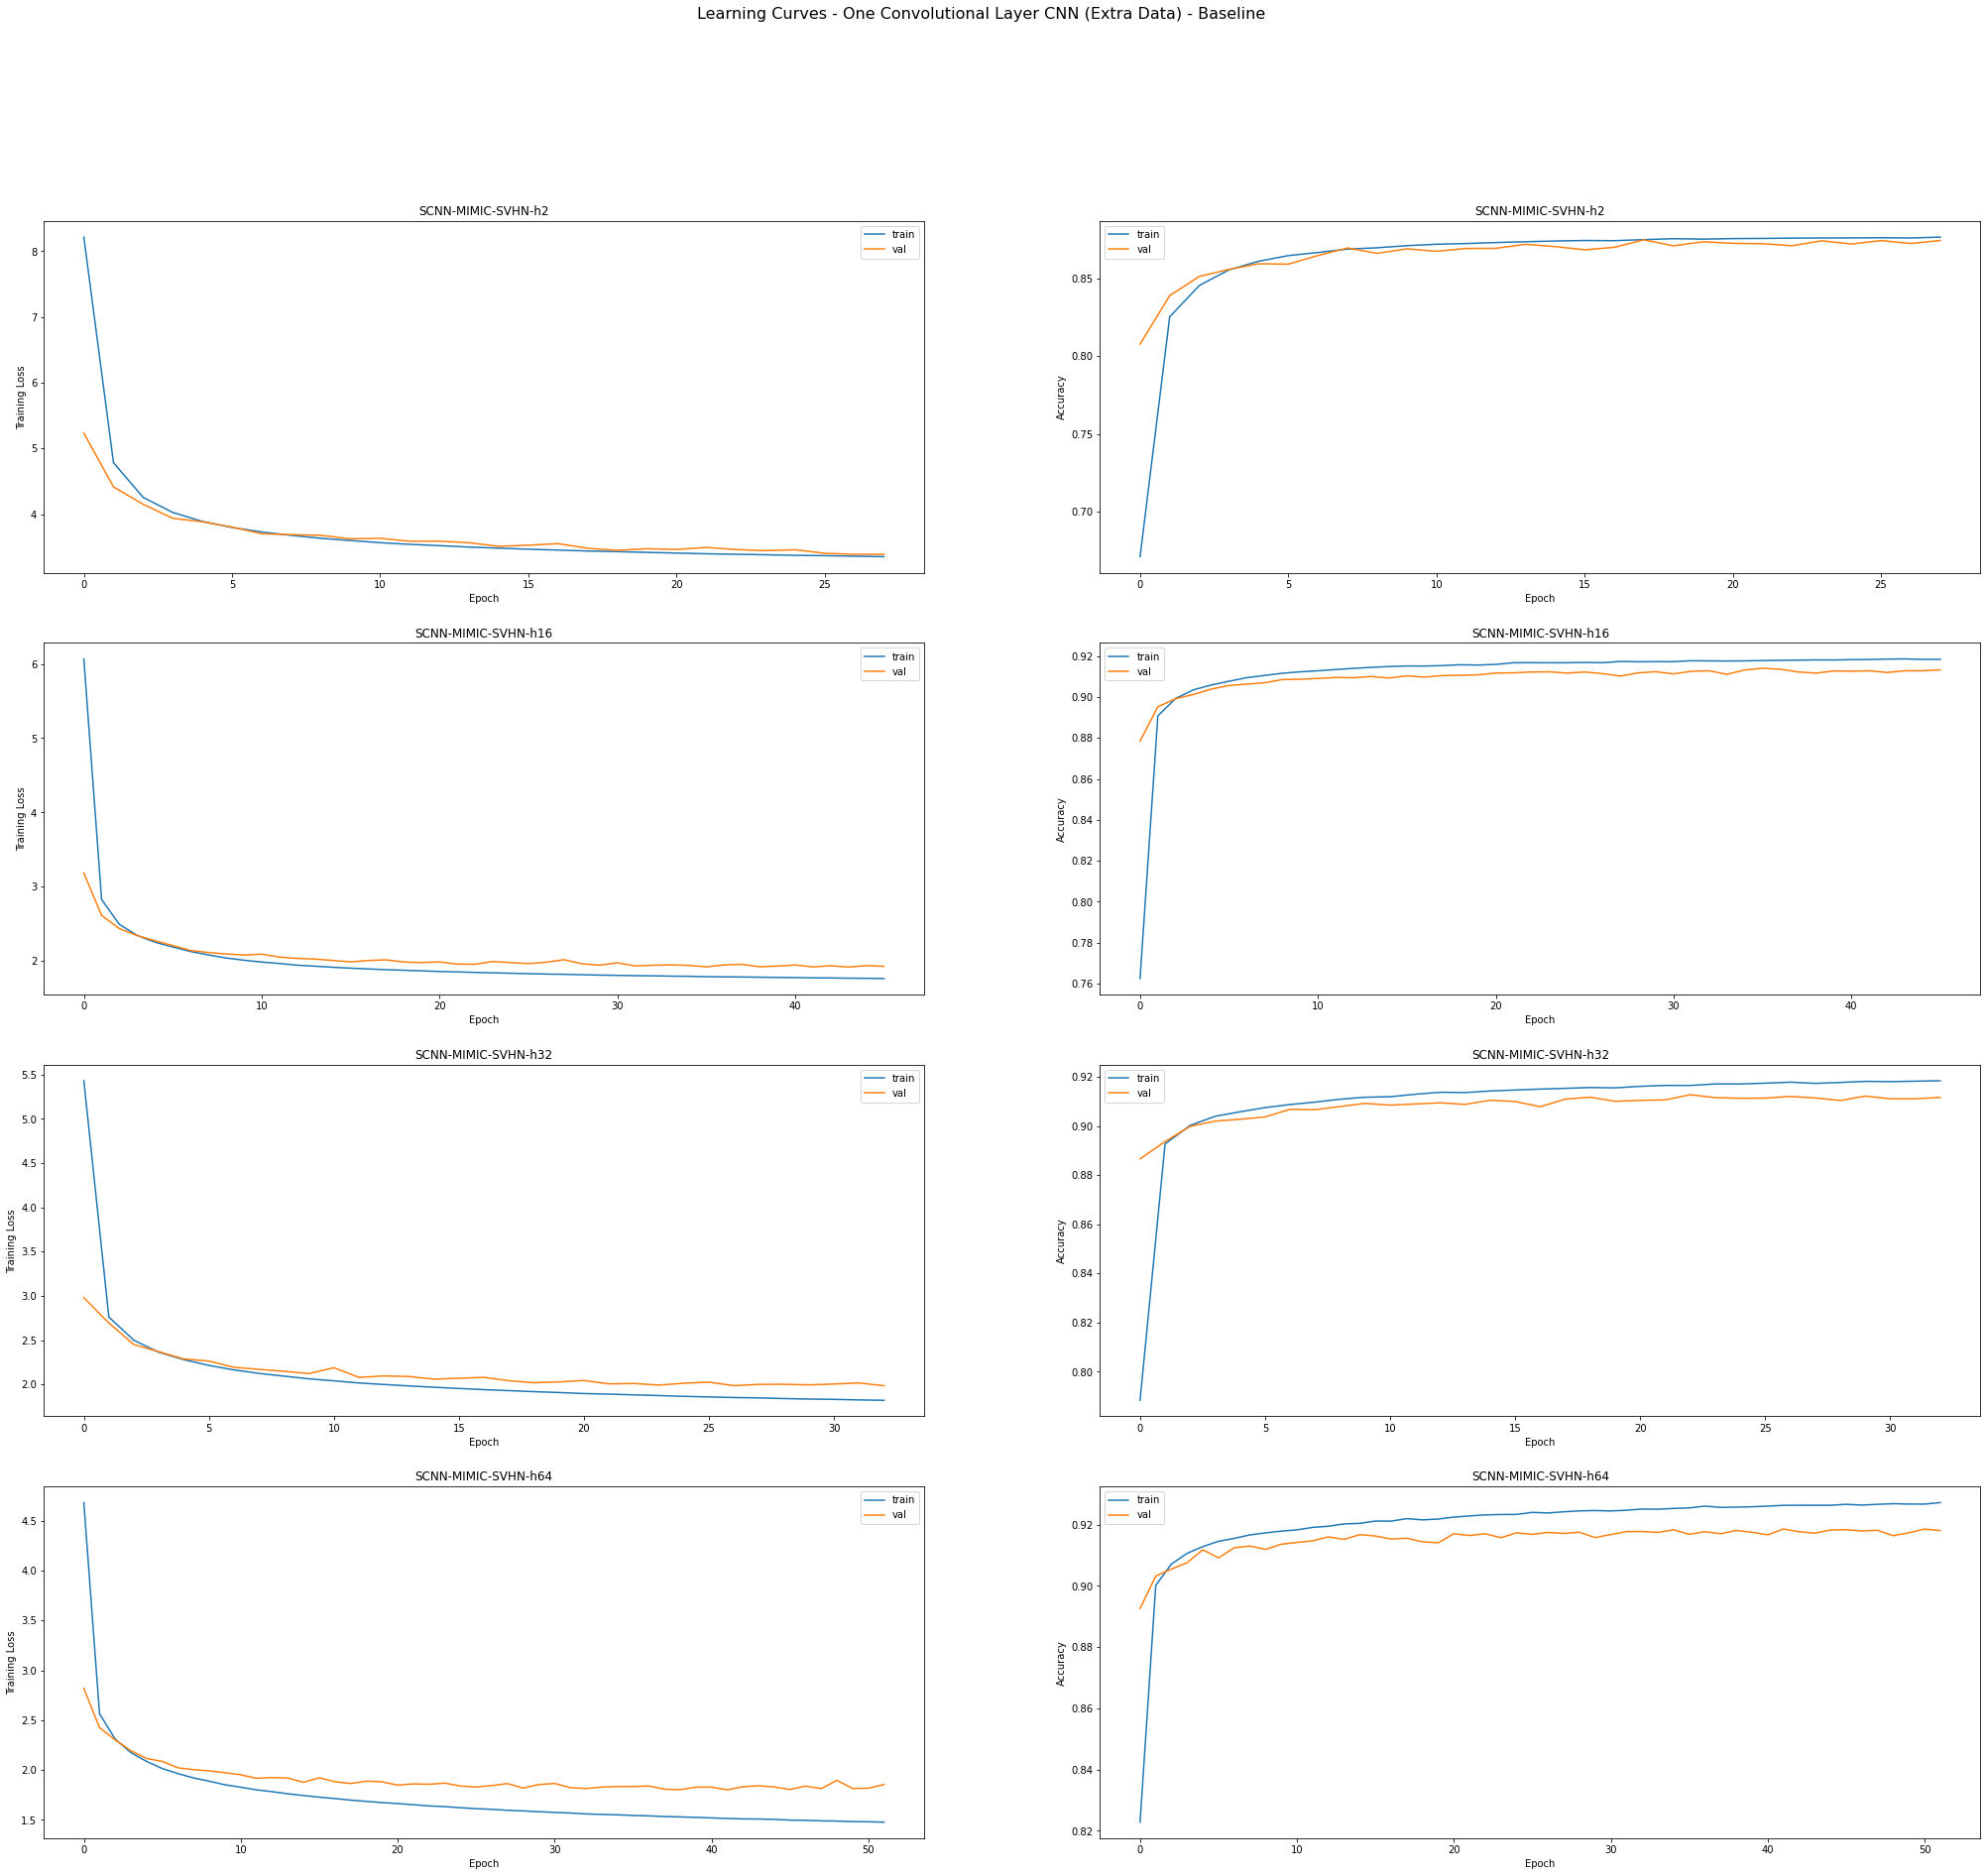

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Extra Data) - Baseline', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(4, 2, 1)
plt.plot(loss_train_2, label='train');
plt.plot(loss_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_2, label='train');
plt.plot(acc_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_32, label='train');
plt.plot(loss_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_32, label='train');
plt.plot(acc_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Baseline_78


In [ ]:
loss_train_2=[4.1539107849051495, 2.0816926392775783, 1.678759279637682, 1.5168616976705747, 1.4174940039387798, 1.340323511409456, 1.2880381958527698, 1.2446272233684665, 1.2092345582115323, 1.1796855171885854, 1.1556058398969782, 1.1392062981746858, 1.1257037697102685, 1.1167033090338796, 1.108432872342109, 1.1007302055370018, 1.0948841517851367, 1.0867434019329854, 1.0818777105336161, 1.0767980651594395, 1.0726817363921766, 1.067578203624758, 1.0643088772236171, 1.0606021920807776, 1.056758397067181, 1.0533740589740916, 1.0502776183987406, 1.0451757413483191, 1.041287687639847, 1.0383342879144362, 1.0355165574774758, 1.0333169116516998, 1.0309503175375896, 1.0294969618480942, 1.027108088754906, 1.0264254603171266, 1.024910825502286, 1.0229961561918317, 1.0220980954520809, 1.0206109662129856, 1.0195728879017738, 1.0185087620106617, 1.0180583966855012, 1.0167433524592784, 1.0163425196095384, 1.0155097648958422, 1.0156152560831972, 1.0141415341869617, 1.0136512720075155, 1.013470125328991, 1.0123625885781982, 1.0118847102459299, 1.011025652841805, 1.0097248144225464, 1.0100861061695117, 1.008616577806186, 1.0091242279453467]
loss_test_2=[2.4543644700587266, 1.8440135238599915, 1.5858655227378982, 1.4500850141718953, 1.3411336096168003, 1.3243426076528277, 1.2578143310224577, 1.237108853986714, 1.208200124948587, 1.1537934879892293, 1.1543656368533566, 1.146899493934643, 1.1374611770757599, 1.1145037713317885, 1.1036463321151366, 1.1154563392788837, 1.104160439965079, 1.1049636985816929, 1.1176177405410572, 1.0781325838461617, 1.0756994957420105, 1.074975559359463, 1.0811234013293858, 1.0715175819846756, 1.055843242383402, 1.0849964485678212, 1.0448002676372758, 1.0798822732361688, 1.056710256463841, 1.0495915373501943, 1.0389994841169947, 1.0338530288810108, 1.0379308428420453, 1.0345104040637152, 1.028995382076222, 1.0407275636740612, 1.0320270412206836, 1.0330650335613882, 1.0224011871044822, 1.0289568677977348, 1.0313571995318487, 1.0260220890105676, 1.0399416117545293, 1.023440395525379, 1.0233323311356166, 1.0173780512329222, 1.021151669756408, 1.022778985254055, 1.0226934567662391, 1.0261290895774693, 1.022028876876937, 1.0160939004154215, 1.0223990883837937, 1.0310600556592626, 1.0230276080392628, 1.0200634188030198, 1.0157683342850943]
acc_train_2=[0.603501, 0.7770249, 0.8174764, 0.83341885, 0.8419666, 0.8478033, 0.85149354, 0.8538352, 0.8563628, 0.85770905, 0.85962003, 0.8605097, 0.8610674, 0.86175233, 0.8621924, 0.86250544, 0.86315733, 0.86415285, 0.8646847, 0.8647812, 0.865073, 0.8654755, 0.86613446, 0.8664404, 0.86655104, 0.86706644, 0.86745477, 0.86783606, 0.86822903, 0.8685068, 0.8693069, 0.8692058, 0.86923164, 0.86922926, 0.86951876, 0.8700036, 0.8699965, 0.8703848, 0.8699965, 0.87004125, 0.8701001, 0.87055194, 0.87059665, 0.87063193, 0.870679, 0.870486, 0.87101084, 0.8705802, 0.8710838, 0.8708579, 0.87083673, 0.8708226, 0.87097085, 0.8707684, 0.8709638, 0.870952, 0.8712368]
acc_test_2=[0.7508637309074402, 0.8093140125274658, 0.8251950740814209, 0.8354655504226685, 0.8486449122428894, 0.8485601544380188, 0.8531728982925415, 0.8575597405433655, 0.8582375645637512, 0.8590847849845886, 0.8565053939819336, 0.8572584986686707, 0.8574562072753906, 0.8625867366790771, 0.8616359233856201, 0.8605157136917114, 0.8640929460525513, 0.8641117811203003, 0.8606569170951843, 0.8679525852203369, 0.8638105392456055, 0.8678207993507385, 0.8657874464988708, 0.8678960800170898, 0.867830216884613, 0.864554226398468, 0.868705689907074, 0.8636505007743835, 0.8680561184883118, 0.8696094155311584, 0.8683479428291321, 0.8697129487991333, 0.8699389100074768, 0.8702778220176697, 0.8688751459121704, 0.8692987561225891, 0.8710309267044067, 0.8711909651756287, 0.8693081736564636, 0.8701177835464478, 0.87056964635849, 0.8702213168144226, 0.8714357018470764, 0.8709367513656616, 0.8708143830299377, 0.8717086911201477, 0.8735255599021912, 0.8695717453956604, 0.870155394077301, 0.870390772819519, 0.8723300099372864, 0.8713791966438293, 0.8700801134109497, 0.8689316511154175, 0.8715863227844238, 0.8703060150146484, 0.8715298175811768]

loss_train_16=[1.8016444043843107, 0.7031718456787568, 0.6168900600999255, 0.5676053196812938, 0.5375081472188745, 0.5179892437072398, 0.5041182674966251, 0.4940801085089752, 0.48447873680673237, 0.47815791965529725, 0.4716022097370664, 0.466591475227652, 0.46137118791514, 0.4561880936793287, 0.45201994922962685, 0.4491467898116398, 0.44516308150132444, 0.4427541684636852, 0.4393075265487896, 0.43736908778009853, 0.4344858066106878, 0.4328712544103793, 0.4304118215175883, 0.4288940071630942, 0.42693168801561804, 0.425280370741099, 0.423563323920195, 0.42220110650052506, 0.4209161563904525, 0.41901125457583416, 0.418191620697468, 0.4166145954521177, 0.4157855855340826, 0.4143113733996598, 0.4135203579334768, 0.41263871172855554, 0.4114301540237378, 0.41060000704214766, 0.4096289697680393, 0.4086835545048825, 0.4078417020320282, 0.4072354953714534, 0.4059885044148221, 0.40594072179073126, 0.40487798419024845, 0.40383794921037425, 0.403262602897557, 0.40253380932919786, 0.40221761835417535, 0.40137829171750045, 0.4011743642055773, 0.40040430323353055, 0.39967038956019846, 0.39936906088097224, 0.39854465259739064, 0.39826739826314256]
loss_test_16=[0.7748501737644287, 0.6771604439111516, 0.5916478197053707, 0.5487866195544333, 0.5338844267530853, 0.5228072113613585, 0.5015740926274223, 0.5004833850196739, 0.5053859533856764, 0.4851827618828372, 0.4914203546344754, 0.4783831534820022, 0.4785735290094071, 0.47494994246696076, 0.4896678177040633, 0.46137859968116224, 0.46268679108080535, 0.46469442315738907, 0.4711093626175678, 0.46041455646355384, 0.4587738665967078, 0.4616337404685664, 0.4513016354268749, 0.46473501239932175, 0.4554979474044557, 0.45050108679095463, 0.44875468532371177, 0.4535126133454126, 0.451672042698689, 0.44240175636991846, 0.45742806613546844, 0.4453717696387511, 0.4502245299834783, 0.4466192394609195, 0.4392395677812809, 0.4401385787835639, 0.4494848092903172, 0.4386570983799527, 0.43919974939511425, 0.4347323750605569, 0.4413558933785887, 0.4380013402625584, 0.4393018076920719, 0.44407157575307454, 0.4361432176987234, 0.43474375720200387, 0.437849100344845, 0.435626581012577, 0.4418988849269527, 0.4358572401657995, 0.438931857148767, 0.4323920423153619, 0.4419165918940221, 0.433601169461919, 0.4361053758427975, 0.4360255848554324]
acc_train_16=[0.8049253, 0.8938866, 0.9004575, 0.9044137, 0.9066754, 0.9080781, 0.90949017, 0.9104904, 0.91073513, 0.9113706, 0.91215426, 0.91267675, 0.9132086, 0.9134463, 0.9136652, 0.9139594, 0.9145407, 0.9144819, 0.91512203, 0.91543734, 0.91548914, 0.91567975, 0.91607517, 0.9164517, 0.9160422, 0.91643995, 0.91685414, 0.917033, 0.9170636, 0.91733664, 0.9168471, 0.9172119, 0.9173931, 0.9172566, 0.9174402, 0.9176896, 0.91747075, 0.917732, 0.91804266, 0.9178144, 0.91776496, 0.9178261, 0.91807324, 0.91808975, 0.91817683, 0.9180544, 0.9180615, 0.9184357, 0.9182051, 0.9182992, 0.9182521, 0.9182639, 0.91832507, 0.91851103, 0.91892284, 0.9186263]
acc_test_16=[0.8897926211357117, 0.8995641469955444, 0.9056925177574158, 0.9063703417778015, 0.9075376391410828, 0.9077070951461792, 0.9104371070861816, 0.9115478992462158, 0.9092603325843811, 0.9123669266700745, 0.9124516248703003, 0.9133647680282593, 0.9134024381637573, 0.9131011962890625, 0.9123857617378235, 0.914720356464386, 0.9142684936523438, 0.9132800698280334, 0.9145979881286621, 0.9150498509407043, 0.9143155813217163, 0.9163583517074585, 0.914720356464386, 0.9131011962890625, 0.9143438339233398, 0.9163395166397095, 0.914701521396637, 0.9152945876121521, 0.9153510928153992, 0.9160288572311401, 0.916330099105835, 0.9169890880584717, 0.915633499622345, 0.9162265658378601, 0.9166407585144043, 0.9166878461837769, 0.9162454009056091, 0.9164807200431824, 0.916546642780304, 0.9172526597976685, 0.9165937304496765, 0.9165089726448059, 0.9164807200431824, 0.9164525270462036, 0.916565477848053, 0.9173374176025391, 0.9154263734817505, 0.9169608354568481, 0.9166878461837769, 0.9163395166397095, 0.9163395166397095, 0.916348934173584, 0.9161607027053833, 0.9157370328903198, 0.9153887629508972, 0.9161136150360107]

loss_train_32=[1.556693901891209, 0.7053805961165474, 0.6064043893018296, 0.5601066948633006, 0.532574487855155, 0.5125159647689511, 0.4968876828359628, 0.48464740199343176, 0.4737743764883999, 0.4653496849465747, 0.4577441433046896, 0.4520586530416163, 0.4461919899538995, 0.4421178545810757, 0.43758086281926306, 0.4337378350371748, 0.4298717595990766, 0.42686166121315394, 0.4240965414488948, 0.42082140823472025, 0.4185886550200575, 0.4158530701624798, 0.41386380311520893, 0.411507912046223, 0.4100833415245562, 0.40776042747409574, 0.40649692643037316, 0.4047933152043, 0.4033546369579833, 0.4017922866768203, 0.40011662926996283, 0.3987527633020583, 0.3977335896751552, 0.3965418567636238, 0.3957103062516122, 0.39397214969100974, 0.39354313679811426, 0.3922165352797496, 0.39146866629483834, 0.3900916118843847]
loss_test_32=[0.7968753790458594, 0.6687677152541053, 0.5911538034434266, 0.5592803005310231, 0.5399484692069926, 0.5344755407129428, 0.5108466223435661, 0.5148800160080298, 0.49644192762816897, 0.49280933370572433, 0.4777827826375086, 0.48245428366112625, 0.4798085876906506, 0.4811514141123015, 0.46595702685933155, 0.4578254462254677, 0.4610503141011914, 0.4659981044829052, 0.4579220195341426, 0.46537182874281047, 0.4577391081279532, 0.4550368672997222, 0.4611901007731201, 0.44959974179861356, 0.458549371569931, 0.4515216007531466, 0.45708389925091725, 0.4545029444611228, 0.4535767334200751, 0.4496904183376404, 0.4572734938880106, 0.44371545602439993, 0.45163077549270847, 0.4436199426397381, 0.4505718711482401, 0.44991664838550516, 0.4413294851607678, 0.4460886556874035, 0.45544649569870443, 0.4504518032697364]
acc_train_32=[0.827328, 0.89200383, 0.9004693, 0.9038371, 0.90623766, 0.9077603, 0.90895826, 0.909902, 0.9110034, 0.91167414, 0.91216135, 0.9126603, 0.913637, 0.9142112, 0.9141665, 0.9143995, 0.9148043, 0.9148137, 0.91552913, 0.91549623, 0.9158398, 0.9159622, 0.91597867, 0.91654116, 0.91677886, 0.91675293, 0.9170307, 0.91732955, 0.9169765, 0.91736484, 0.91771317, 0.9176355, 0.9176708, 0.9175014, 0.91779554, 0.918158, 0.91803324, 0.9181556, 0.91840744, 0.91844743]
acc_test_32=[0.8828452229499817, 0.8943583369255066, 0.9023224115371704, 0.9039792418479919, 0.9068222045898438, 0.9081401228904724, 0.908723771572113, 0.9092885851860046, 0.9097781181335449, 0.9101923108100891, 0.9119997620582581, 0.9113596081733704, 0.9113878607749939, 0.9112749099731445, 0.9136001467704773, 0.9140896201133728, 0.9127058386802673, 0.9113878607749939, 0.914023756980896, 0.913072943687439, 0.9143814444541931, 0.9141649603843689, 0.9130352735519409, 0.9136660099029541, 0.9128187894821167, 0.914955735206604, 0.913807213306427, 0.9150121808052063, 0.9139295816421509, 0.9162077307701111, 0.9147297739982605, 0.9152757525444031, 0.9138166308403015, 0.9159253239631653, 0.915633499622345, 0.9158594608306885, 0.9159535765647888, 0.9155769944190979, 0.9149839282035828, 0.9143155813217163]

loss_train_64=[1.4356202504286204, 0.6820341620169993, 0.5986266240322976, 0.5572923345683225, 0.5310917455215063, 0.5124693381930664, 0.4966630445717486, 0.48620664916171297, 0.4754249603417535, 0.4676440782463324, 0.45944054923675137, 0.4527323461457844, 0.44692192411857257, 0.44088596257636814, 0.4348958812911709, 0.4307947679053742, 0.4264321498079188, 0.42267788020036867, 0.4187887500699206, 0.4150880197069366, 0.4117889065194668, 0.4086721317487945, 0.4064189141889662, 0.4034984978832424, 0.40198830599803975, 0.39818185498951325, 0.39656000663438595, 0.39420813838794966, 0.39244541560798013, 0.390454289285316, 0.38880026111214405, 0.38727454225288854, 0.3855957984851372, 0.3835512111520192, 0.3821941759490137, 0.38138695628182073, 0.3794490680405181, 0.3787474489723994, 0.3767308032049411, 0.3755807508250791, 0.3746702822730723, 0.3738340555610428, 0.3726976012666473]
loss_test_64=[0.7564865343468161, 0.6271028835623293, 0.5855892516553166, 0.5704975214236321, 0.5561579582896041, 0.5297291545779849, 0.5219023845952299, 0.5187612917482793, 0.5021178053074293, 0.5035724327625669, 0.4903873355985075, 0.483760282413402, 0.47776876284338016, 0.47465556035676804, 0.4690318658726448, 0.47524301377126704, 0.46466099730919586, 0.46434111190208965, 0.45697193924197244, 0.45934579238037865, 0.45600094065968344, 0.46554549135495615, 0.4551794314781275, 0.4552747053573472, 0.4609956626126651, 0.46007051720544867, 0.45340053571903693, 0.45732187601655816, 0.4528479556185953, 0.46168978280732575, 0.45498201726820103, 0.4572785870694728, 0.4449565976537467, 0.46091503100297254, 0.44988297733664034, 0.4590695543789445, 0.44587707485163486, 0.4506269618054522, 0.4498874754260967, 0.451060813546211, 0.4451525029684463, 0.453854454949679, 0.44340135826157495]
acc_train_64=[0.8358594, 0.89366066, 0.90048575, 0.9041219, 0.90579283, 0.9078521, 0.90910417, 0.9097773, 0.9110999, 0.91145295, 0.9122437, 0.91324157, 0.9130792, 0.9143783, 0.91455245, 0.9151079, 0.91550565, 0.91592216, 0.9161999, 0.91644466, 0.91672236, 0.91689885, 0.9169765, 0.91729426, 0.91762376, 0.9176826, 0.91819566, 0.9184757, 0.91846156, 0.91892993, 0.91827804, 0.91905934, 0.91903114, 0.91929233, 0.91951597, 0.91967595, 0.9194218, 0.920149, 0.92015845, 0.9200643, 0.9203232, 0.9201043, 0.9203702]
acc_test_64=[0.8906963467597961, 0.8993287682533264, 0.9033673405647278, 0.9033955335617065, 0.9047605395317078, 0.9057584404945374, 0.9066339135169983, 0.9095427989959717, 0.9078294634819031, 0.9097121953964233, 0.911444365978241, 0.9107100963592529, 0.9112560749053955, 0.9116514921188354, 0.9121503829956055, 0.9122633337974548, 0.9120091795921326, 0.9111996293067932, 0.9134683012962341, 0.9134306907653809, 0.9132518172264099, 0.9125645756721497, 0.9139484167098999, 0.9125363826751709, 0.9135248064994812, 0.9129317402839661, 0.9144002795219421, 0.9124422073364258, 0.9136001467704773, 0.9139013886451721, 0.9130635261535645, 0.9142402410507202, 0.914701521396637, 0.9132518172264099, 0.9142779111862183, 0.9127434492111206, 0.9139672517776489, 0.9134306907653809, 0.9122915863990784, 0.9131764769554138, 0.914023756980896, 0.9137225151062012, 0.9143814444541931]


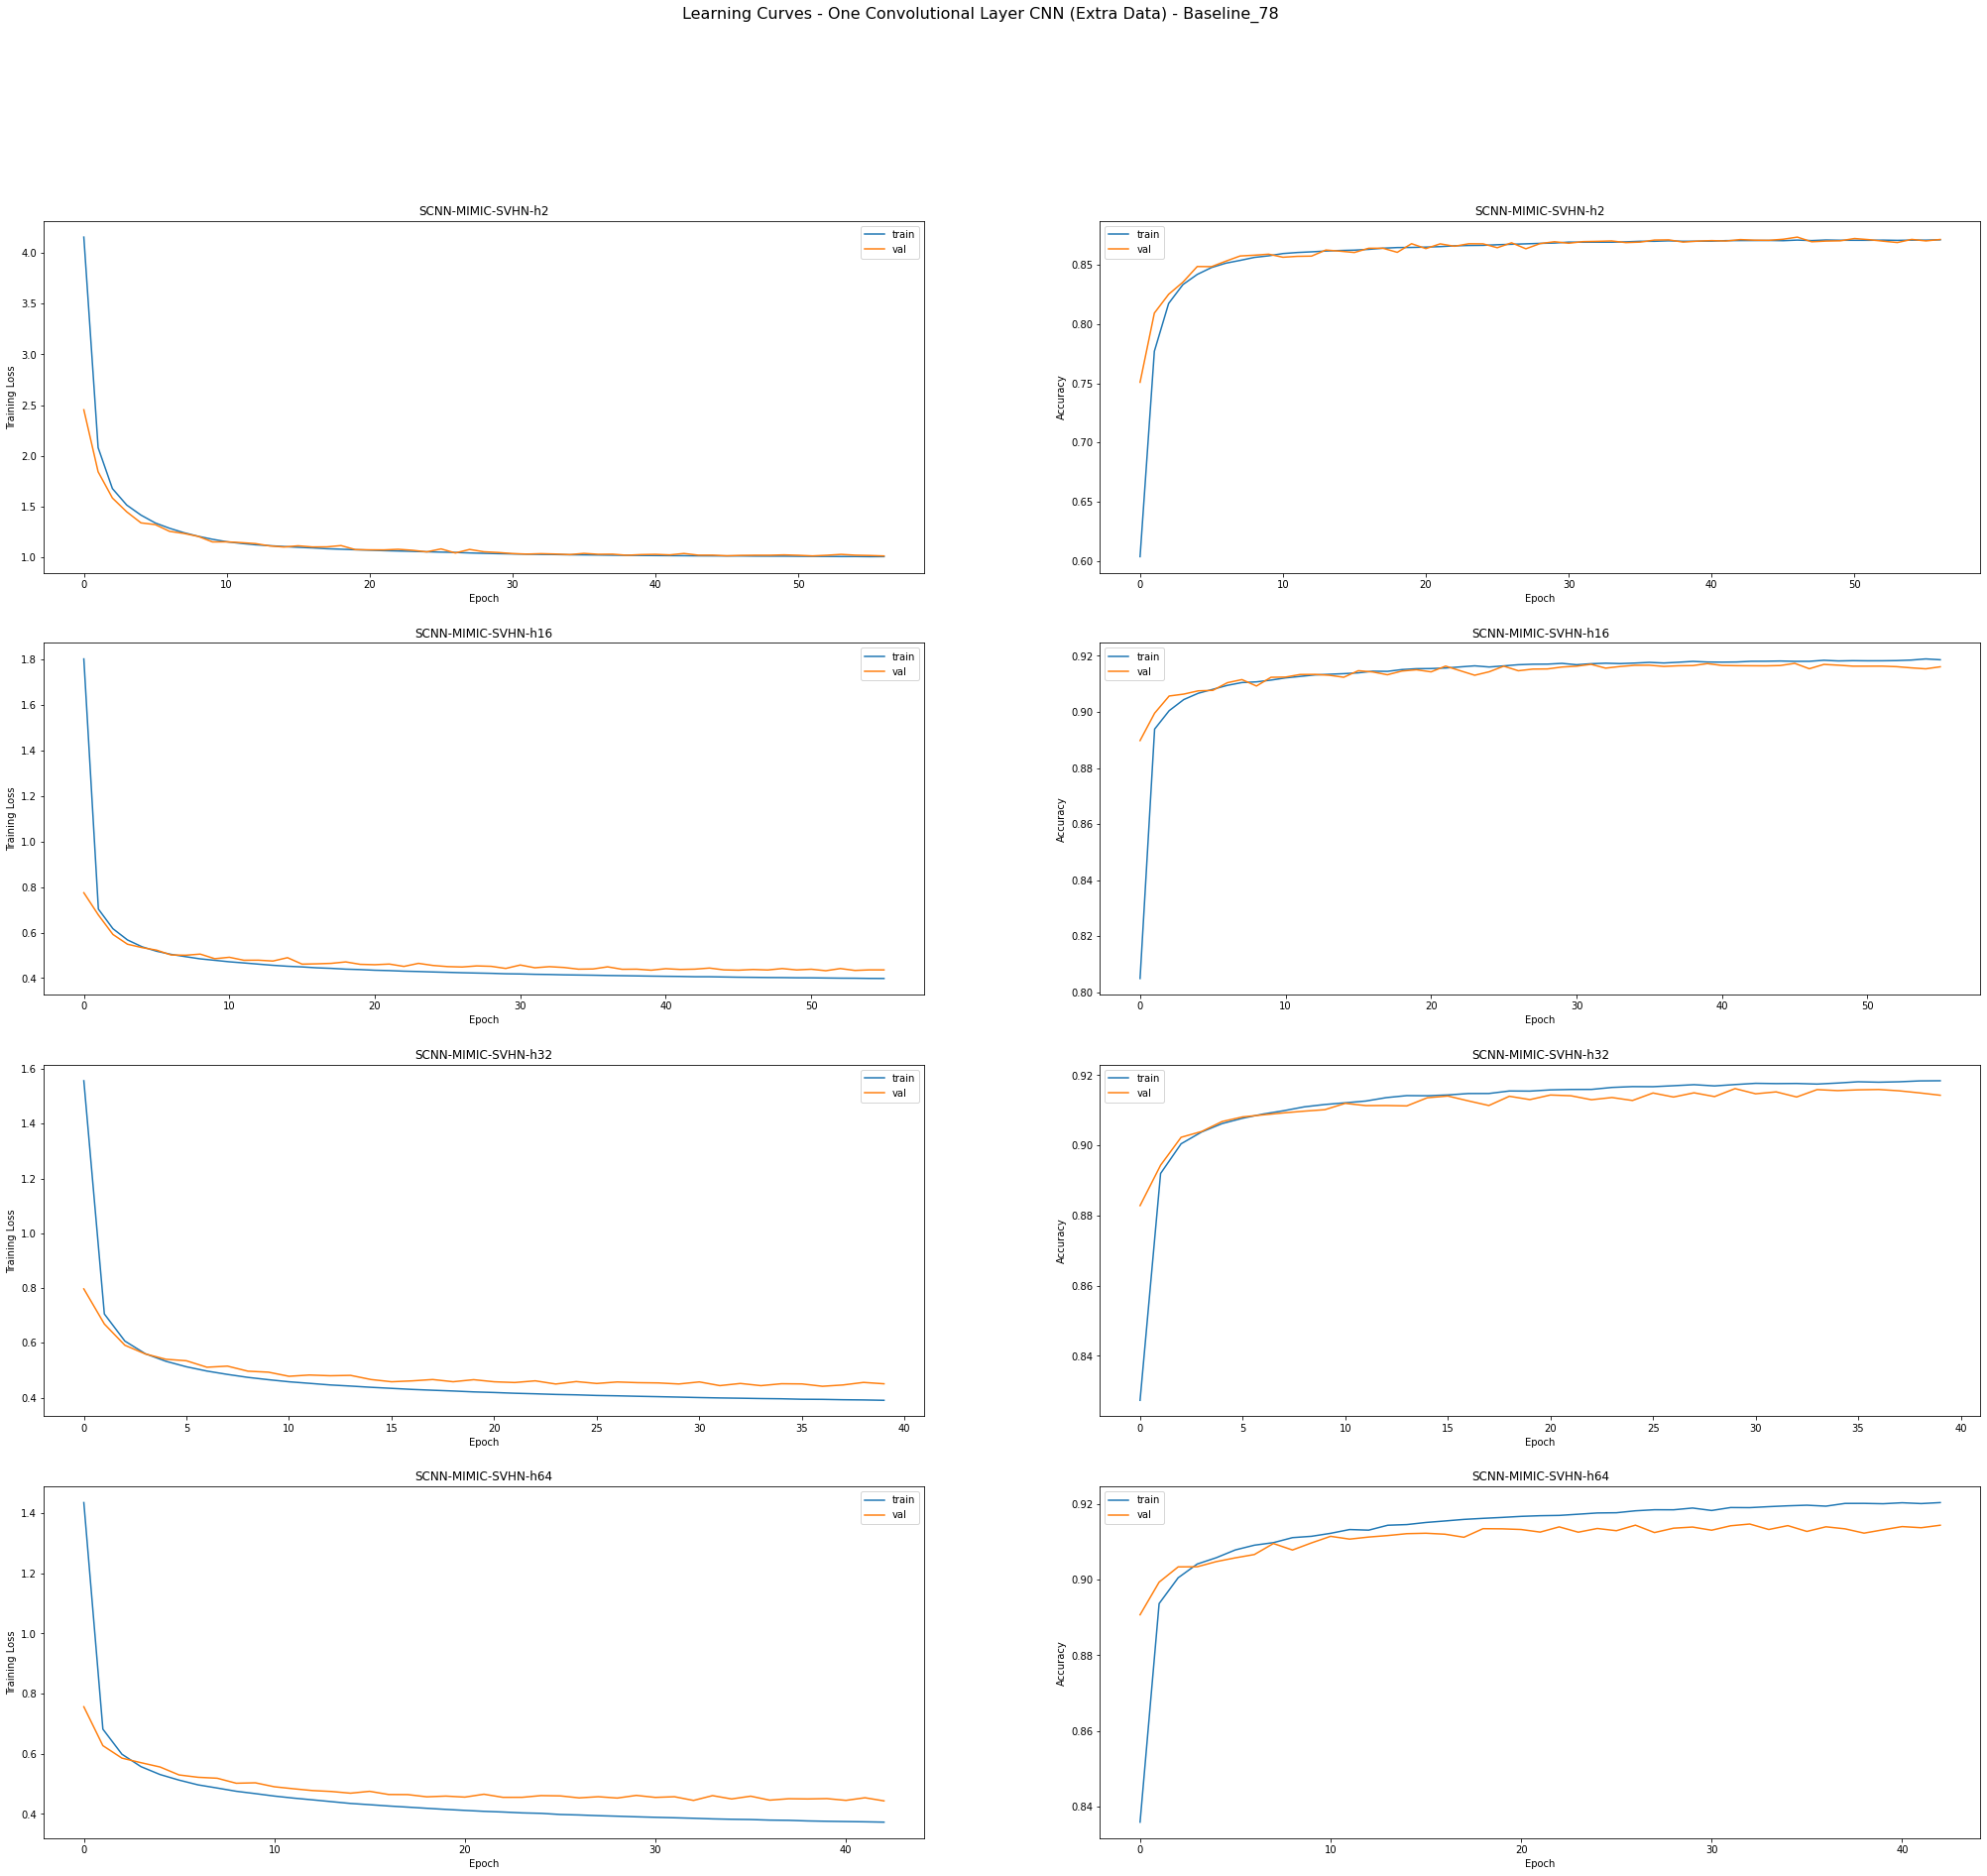

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Extra Data) - Baseline_78', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(4, 2, 1)
plt.plot(loss_train_2, label='train');
plt.plot(loss_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_2, label='train');
plt.plot(acc_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_32, label='train');
plt.plot(loss_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_32, label='train');
plt.plot(acc_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Robust


In [ ]:
loss_train_2=[0.6577785644785681, 0.2156314136063402, 0.17444384910065686, 0.154437718669612, 0.14089379014012715, 0.1325626124935991, 0.1267026625215225, 0.12207392872352259, 0.11916109607443715, 0.11658875703348168, 0.11484838784107965, 0.11307855932064763, 0.11168080259113031, 0.11005421091328613, 0.10939987366070954, 0.10850411606455439, 0.1074432186710678, 0.10686325443121929, 0.10609077589790025, 0.10539602234446466, 0.10497428941326724, 0.10428845905519543, 0.10385576526743479, 0.10329075122348443, 0.10287887564678502, 0.1024812502501788, 0.1022382285854488, 0.10189321989643955, 0.10152533215536735, 0.10111488472758201, 0.10084437771433953, 0.10059304194667933, 0.10012010172170227, 0.0999509254738223, 0.09960625147906715, 0.09952463874167598, 0.09920708475985467, 0.09899261520425262, 0.0987281110003385, 0.09865101073101025, 0.09843701916382722, 0.09803867753080084, 0.09803673414771896, 0.09774870512280721, 0.09759675720104614, 0.09734417081346056, 0.09722483730697942, 0.09699798599335828, 0.09705288286688901, 0.09678242197926756, 0.09679232349184863, 0.09666171259338525]
loss_test_2=[0.24426883779090142, 0.18479668334978933, 0.1581032985962923, 0.14147591948306096, 0.1366035592044888, 0.12698227380981175, 0.12725948402619966, 0.12705429902911267, 0.12503402645384049, 0.12040112431085348, 0.1232661224504483, 0.11573233733293435, 0.10937908641526248, 0.10792224225483155, 0.11665023102981402, 0.10733682191767946, 0.11047933132405487, 0.10809699649265767, 0.10854750532644879, 0.10596056434566088, 0.10572057404537609, 0.10260081585674359, 0.10148776467565053, 0.10910882163449767, 0.0992757512062974, 0.10282146817996368, 0.10117047561685431, 0.1034054625532679, 0.10500478742143175, 0.11186389395425676, 0.11220938844253538, 0.09941441925344051, 0.10177910604179105, 0.10563156483696927, 0.10000550828215021, 0.1006296212169684, 0.09644249785470459, 0.1067171491222352, 0.0974731991685605, 0.0978839266520099, 0.09748570306639778, 0.09627961688167229, 0.09564287455147848, 0.1071382403260515, 0.0998248842107971, 0.09819214583036327, 0.10167098403692681, 0.10674435890426115, 0.10018612098604969, 0.09999994335991857, 0.10137785897351162, 0.10844142392982047]
acc_train_2=[0.778943, 0.8991019, 0.90941954, 0.9152538, 0.9194383, 0.9221518, 0.92444414, 0.92569613, 0.9271812, 0.92779547, 0.9288757, 0.9297394, 0.929883, 0.9303584, 0.93017715, 0.9307867, 0.9311468, 0.93165517, 0.9316034, 0.93193287, 0.9321188, 0.9324247, 0.93257064, 0.9328813, 0.9328319, 0.9329213, 0.933159, 0.93286014, 0.9330813, 0.9333544, 0.9336038, 0.93403685, 0.93366975, 0.9340251, 0.9341522, 0.9339592, 0.9344252, 0.9340133, 0.93407685, 0.9343969, 0.9341522, 0.9343852, 0.9342958, 0.93470997, 0.9347217, 0.93488884, 0.93475235, 0.93484646, 0.93508416, 0.93488646, 0.93478996, 0.9350936]
acc_test_2=[0.8855469822883606, 0.9020399451255798, 0.9150027632713318, 0.9211970567703247, 0.9188059568405151, 0.9218936562538147, 0.9230515956878662, 0.9264876246452332, 0.9269771575927734, 0.9205098748207092, 0.927523136138916, 0.9298765659332275, 0.9296600818634033, 0.9318252205848694, 0.9281915426254272, 0.9322865009307861, 0.929368257522583, 0.9259980916976929, 0.9274760484695435, 0.9325689077377319, 0.9305449724197388, 0.9344611167907715, 0.9336420893669128, 0.9318628907203674, 0.9335103034973145, 0.933557391166687, 0.9306673407554626, 0.9316464066505432, 0.9330490231513977, 0.9316369891166687, 0.9299048185348511, 0.9347717761993408, 0.9340939521789551, 0.9275890588760376, 0.9357696175575256, 0.9341316223144531, 0.9350918531417847, 0.9336515069007874, 0.9339339137077332, 0.9346870183944702, 0.9353742599487305, 0.9359484910964966, 0.9357602000236511, 0.9324465394020081, 0.9351200461387634, 0.9355813264846802, 0.9318158030509949, 0.9294341206550598, 0.9330678582191467, 0.9340939521789551, 0.9295188784599304, 0.9271089434623718]

loss_train_16=[0.5294878897802743, 0.16547048499900754, 0.13426920880117807, 0.11900582343422403, 0.10933232535708323, 0.10298055317352822, 0.0976940766121392, 0.09372603668218152, 0.09123342352584946, 0.08915662345174202, 0.08747840080113344, 0.08629894584000437, 0.08434754598081912, 0.08256575354901811, 0.08159759471855173, 0.08089727450660089, 0.07998052062218974, 0.07948667193877933, 0.07904816088419486, 0.07858206839493838, 0.07806386792952996, 0.07770099167848997, 0.0773744240160214, 0.07686733274264863, 0.0767174870816073, 0.0764485548318219, 0.07595373997729726, 0.07573962401250592, 0.07537731863897064, 0.07516835879957351, 0.07482570512850988, 0.07472877974459738, 0.07430727397341434, 0.07424118010748369, 0.07389686303233403]
loss_test_16=[0.19122741057643572, 0.14384627578716422, 0.12607824951975607, 0.12257879069469428, 0.10429445736994164, 0.10279348068980064, 0.09714803793278953, 0.09317932773465953, 0.090753719952758, 0.08970611562263343, 0.0853191613455229, 0.09174053509924622, 0.0897671970891652, 0.08529421522224016, 0.08456311023558967, 0.08131608325086671, 0.08939414406278484, 0.08437486576613391, 0.08437260427655775, 0.08208816142341703, 0.08145029409279651, 0.08331342914777351, 0.07871882146403776, 0.07967730156912277, 0.0774442950457359, 0.07732563814252655, 0.08005257594023414, 0.07676382336603824, 0.07796462032764866, 0.07684618634534898, 0.08132947652773694, 0.08198284973698597, 0.07609797552366426, 0.07768726647076926, 0.0761830440047772]
acc_train_16=[0.81436276, 0.90565866, 0.91643757, 0.92161995, 0.9261527, 0.92881453, 0.9310103, 0.9320223, 0.9328013, 0.933785, 0.9341616, 0.9346229, 0.9352301, 0.93602556, 0.93643034, 0.9365198, 0.93695986, 0.93733877, 0.9374235, 0.93738353, 0.9375883, 0.9375953, 0.93799543, 0.9380166, 0.9380731, 0.9377859, 0.93822604, 0.93793184, 0.93823075, 0.93828255, 0.93879086, 0.93879557, 0.93894386, 0.9386355, 0.9391416]
acc_test_16=[0.8969376683235168, 0.9100699424743652, 0.9196155667304993, 0.9202744960784912, 0.9254144430160522, 0.9303660988807678, 0.9304602146148682, 0.9315145611763, 0.9336138367652893, 0.9306673407554626, 0.934489369392395, 0.931194543838501, 0.9341222047805786, 0.9332278966903687, 0.9352518916130066, 0.9363815188407898, 0.9310815334320068, 0.9356566667556763, 0.9347152709960938, 0.9373323321342468, 0.9362026453018188, 0.9364944696426392, 0.9391209483146667, 0.9352706670761108, 0.9392998218536377, 0.9390079975128174, 0.9364756345748901, 0.9374452829360962, 0.9363532662391663, 0.9375205636024475, 0.9365886449813843, 0.9376335740089417, 0.9378783106803894, 0.9352800846099854, 0.9383301734924316]

loss_train_32=[0.4128323010166743, 0.13331250718382365, 0.10640112626834372, 0.09436258626099668, 0.08649386308087516, 0.08142434467575904, 0.07759034287725178, 0.07407905620847031, 0.07118665261806317, 0.06914793366861831, 0.06724583524797852, 0.06593345627846586, 0.06425377507160221, 0.06269807876968232, 0.06148905735659644, 0.06045643546804793, 0.05964182303011706, 0.058765721580507864, 0.058142942584940384, 0.05752237629713299, 0.05700875843698869, 0.05654660777150244, 0.056220659471634044, 0.055816866780802894, 0.055347147557491046, 0.05518474906720563, 0.054855444419793724, 0.05464110529802857, 0.05439676803903031, 0.05412816516991208, 0.053859990920366564, 0.05358331593830268, 0.05336901027843001, 0.0533461320302296, 0.05298478698761835, 0.052870156032991555, 0.05267981416241142, 0.052499759697297796, 0.05231235156777118, 0.052055254443713186, 0.05192053509860736, 0.05179167199163275, 0.05169538111759921, 0.051461422986461794]
loss_test_32=[0.15707841073543574, 0.12078792168965323, 0.10063481382661699, 0.08916305179787935, 0.0862294959590566, 0.07966684591204072, 0.0797353126872803, 0.07539133473032664, 0.06984735539268011, 0.06990553096970754, 0.06815319822905425, 0.06759708155142707, 0.0682976547676791, 0.06611951707427907, 0.06298899074177228, 0.06389009659233832, 0.06681559486710147, 0.06162571123149824, 0.06313631874104678, 0.061677477200609704, 0.05836582236055851, 0.060214699927566964, 0.06172725488612577, 0.06350563280962992, 0.05886480893917254, 0.06293839111098504, 0.05897289421552275, 0.05927323592370457, 0.061382961274406754, 0.05841394942569275, 0.05811350502414146, 0.05791492553406721, 0.059340911867932174, 0.05500019528015581, 0.06185103617613106, 0.0592940829875789, 0.05764643690453826, 0.057204384129734547, 0.05902109558064214, 0.05667154924114816, 0.05907299975585991, 0.0567391964771757, 0.056879934883676146, 0.06333364611211972]
acc_train_32=[0.84707606, 0.9175061, 0.92707056, 0.9314269, 0.93413335, 0.93619734, 0.93724465, 0.9390827, 0.94039124, 0.941022, 0.941921, 0.94237757, 0.9435143, 0.94433093, 0.9447969, 0.9450841, 0.94556415, 0.94602543, 0.946162, 0.9462961, 0.9471763, 0.9468374, 0.9469951, 0.9472775, 0.94739753, 0.947647, 0.9477882, 0.94774586, 0.94774586, 0.9478, 0.9482707, 0.9482142, 0.9482401, 0.94816005, 0.948739, 0.9485578, 0.94853896, 0.9489838, 0.94896495, 0.9491156, 0.9489908, 0.9494003, 0.94932735, 0.94927794]
acc_test_32=[0.9103806018829346, 0.9174692034721375, 0.9280596971511841, 0.9325124621391296, 0.9340375065803528, 0.936136782169342, 0.9380006790161133, 0.9391868114471436, 0.9418603777885437, 0.9420768618583679, 0.9431877136230469, 0.9425287246704102, 0.9411543011665344, 0.9413708448410034, 0.9432629942893982, 0.9421616196632385, 0.9424628615379333, 0.9429053068161011, 0.9443079233169556, 0.9448539614677429, 0.9446845054626465, 0.9455505609512329, 0.9460777640342712, 0.9433289170265198, 0.9450704455375671, 0.9447503685951233, 0.946341335773468, 0.9447692036628723, 0.9449763298034668, 0.946520209312439, 0.9459930062294006, 0.9465296268463135, 0.9458329677581787, 0.9481770396232605, 0.9450704455375671, 0.9472638964653015, 0.9468026161193848, 0.9464637041091919, 0.9451363682746887, 0.9473956823348999, 0.945428192615509, 0.947254478931427, 0.9469626545906067, 0.9433289170265198]

loss_train_64=[0.42233091511595844, 0.14016993340758022, 0.10493154951629347, 0.08933606694280431, 0.08162229223635861, 0.07719753236683927, 0.07404039462237601, 0.0716571079767076, 0.06882754655923225, 0.06686243071604774, 0.06540939304695347, 0.06412914418071386, 0.06308070095291567, 0.06214731462204295, 0.06099175587623334, 0.060412440187170686, 0.05957231104863221, 0.05891867101899755, 0.058190725638983004, 0.05764811421351695, 0.05727141512690041, 0.05671964167640706, 0.0563489156423868, 0.055832555169980695, 0.05556852099673019, 0.05513041356181027, 0.05487658577196072, 0.05437507099009367, 0.054197990814134775, 0.053796792509159086, 0.05366911189389876, 0.053311366185139396, 0.05319763209466046, 0.052921910480756444, 0.052498646547759646, 0.052226965053933996, 0.0519295474632374, 0.05172429090193962, 0.051499672940848625, 0.051191508057517515, 0.05122857848917201, 0.050799455386937094, 0.05078205985894892, 0.05059982139542226, 0.050434516635828534, 0.050244699758129535, 0.05013536258774755, 0.04998044662116261, 0.049858559554116375, 0.04972221757831206]
loss_test_64=[0.17283833829492518, 0.13195159176795768, 0.09339527738168171, 0.08215165345790856, 0.07888200440353899, 0.07830957754256468, 0.0744536117357364, 0.07084131848347563, 0.07037881061226996, 0.06948401397040387, 0.0669295559164648, 0.06551000771004385, 0.06717516468732457, 0.06877115938260822, 0.06583047873228001, 0.06600448782802076, 0.06219679103995718, 0.0650101394682756, 0.06526168419960741, 0.06266956341733529, 0.06356611424312343, 0.06626996826636321, 0.06007784056046801, 0.06375538049202109, 0.06121059416526928, 0.06465359219928325, 0.05988623168271875, 0.059849294111756435, 0.05995535186546711, 0.05782708078410299, 0.05971763472314047, 0.05743313441120103, 0.05810821773095169, 0.0585504221699275, 0.06018878471574499, 0.058494729026449976, 0.05878603547115456, 0.06244032842095273, 0.06084985386859765, 0.056844502737041995, 0.05974237500894052, 0.057952574031515686, 0.057867877833948575, 0.057571666028455065, 0.06309806885348924, 0.055181410125590954, 0.05677447951277687, 0.056410301213838665, 0.056899772813061106, 0.058187928411617976]
acc_train_64=[0.8450756, 0.91540676, 0.9264728, 0.93211645, 0.935376, 0.9366563, 0.93842846, 0.9393769, 0.94123846, 0.94193274, 0.9426317, 0.9435331, 0.9436179, 0.94398737, 0.94412386, 0.944804, 0.94509345, 0.9452488, 0.9455571, 0.9457007, 0.9458207, 0.9463126, 0.9461502, 0.946482, 0.9470045, 0.94661385, 0.94735754, 0.94731283, 0.9471033, 0.9474399, 0.94724923, 0.9477647, 0.94778115, 0.9477717, 0.94792235, 0.9483907, 0.94849426, 0.948619, 0.9481342, 0.9486166, 0.94864017, 0.9487531, 0.9487343, 0.9486519, 0.94909674, 0.9490756, 0.9490426, 0.94915324, 0.9494521, 0.94877905]
acc_test_64=[0.901917576789856, 0.9163960218429565, 0.9305826425552368, 0.9348753094673157, 0.9345458149909973, 0.9370781183242798, 0.9379348158836365, 0.939177393913269, 0.9380289316177368, 0.9396480917930603, 0.9421427845954895, 0.941399097442627, 0.9425663948059082, 0.9409660696983337, 0.9418697953224182, 0.941737949848175, 0.9447786211967468, 0.9410884380340576, 0.9408907294273376, 0.9441102743148804, 0.9437242746353149, 0.9400435090065002, 0.9449857473373413, 0.9416155815124512, 0.9440349340438843, 0.942829966545105, 0.9442608952522278, 0.9457952976226807, 0.945588231086731, 0.9462095499038696, 0.9454187750816345, 0.9466896653175354, 0.9456635117530823, 0.946284830570221, 0.9455505609512329, 0.9457200169563293, 0.946322500705719, 0.9446468353271484, 0.9457482695579529, 0.9477910399436951, 0.9442326426506042, 0.9465672373771667, 0.9474239349365234, 0.9459647536277771, 0.9437242746353149, 0.9468967318534851, 0.9450704455375671, 0.9461812973022461, 0.9475086331367493, 0.946360170841217]


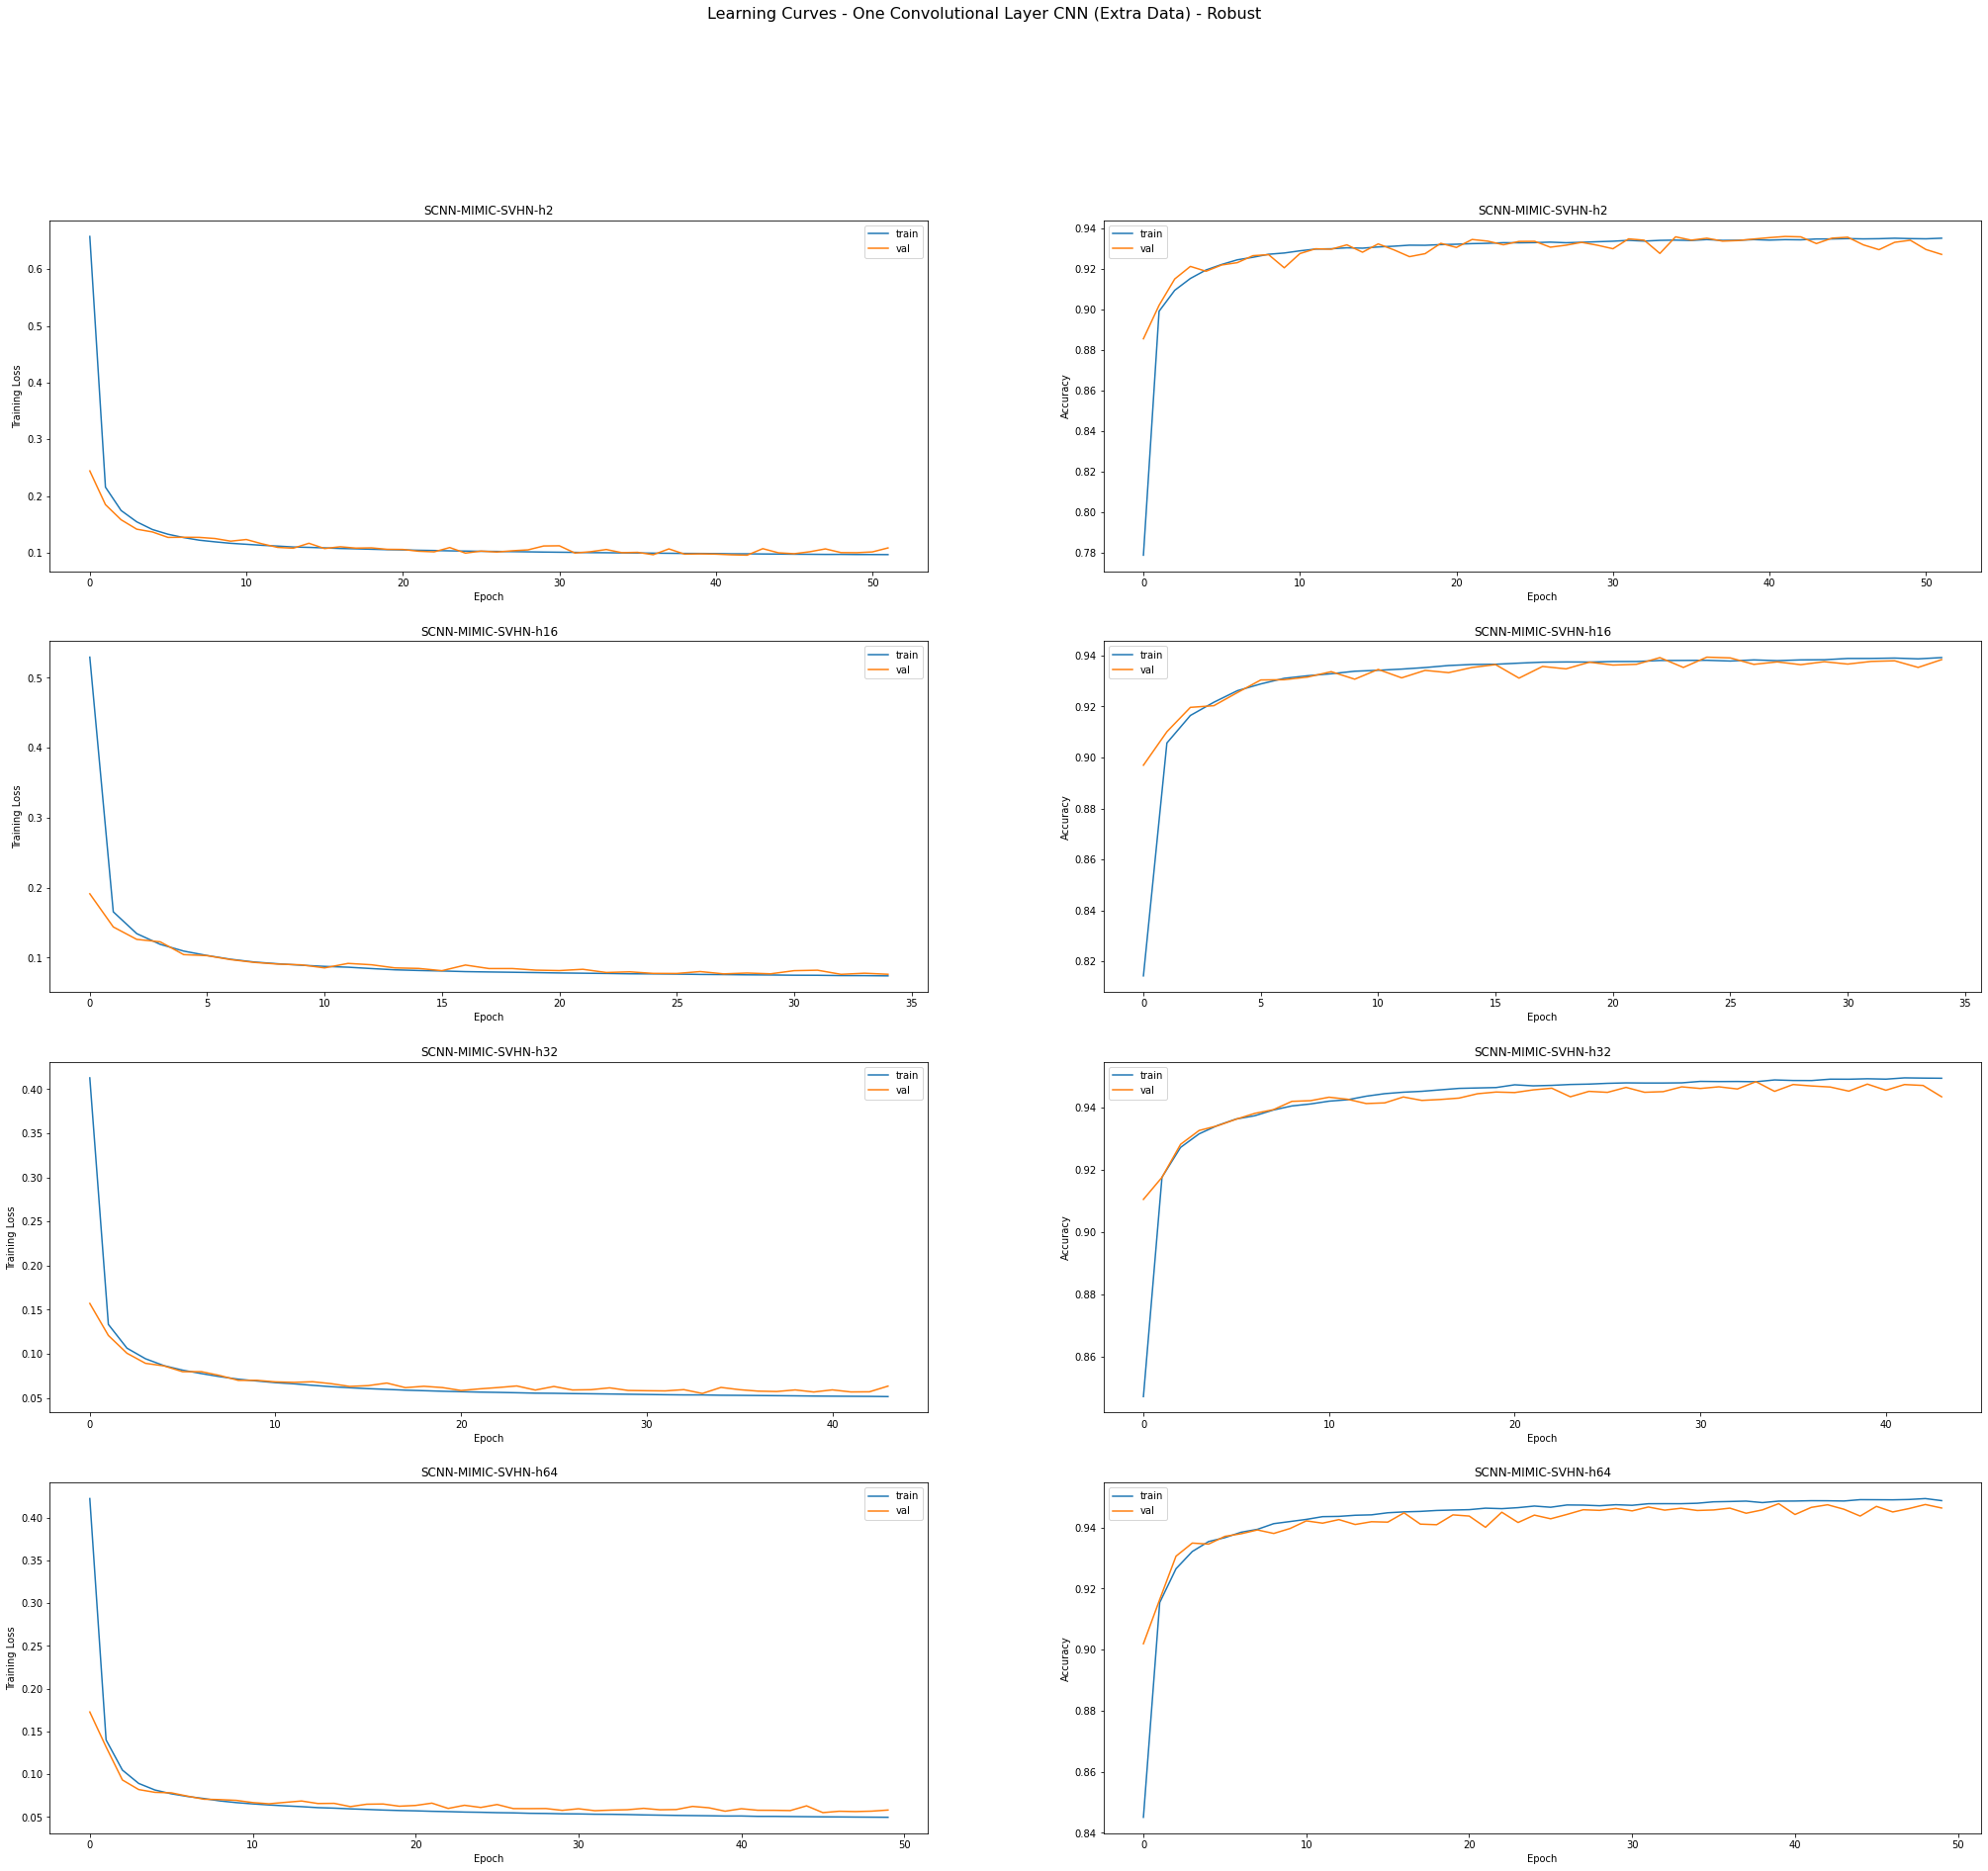

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Extra Data) - Robust', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(4, 2, 1)
plt.plot(loss_train_2, label='train');
plt.plot(loss_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_2, label='train');
plt.plot(acc_test_2, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h2')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_32, label='train');
plt.plot(loss_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_32, label='train');
plt.plot(acc_test_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

### Training / Evaluation and Attacks for 2 Layers


#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

#### Training

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [4, 16, 16, 32] 
channels_to_test2 = [8, 32, 64, 128] 

index_for_two = 0;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras_78.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn_extra, x_test_cnn_extra)
  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_logits, x_test_cnn_extra, test_logits)

  # Learning Curves Data
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_2_layer.append(score)
  channels_number.append(channel)

  index_for_two = index_for_two + 1

  print ('----------------------------')

#### Results

##### Learning Curves for Extra Data - Baseline


In [ ]:
loss_train_4_8=[6.233677599265925, 2.8886575918404302, 2.4936340023168473, 2.3136640676136753, 2.2068429095706525, 2.13314103545573, 2.073633587605251, 2.024628636132833, 1.986144740259255, 1.957383025121898, 1.9302610526313744, 1.9080731761683796, 1.8872292730374767, 1.8667121840109564, 1.8476207890395733, 1.8275922118417804, 1.8140661757758998, 1.79907009928968, 1.787765437149448, 1.775735394384996, 1.7668232444768535, 1.7558228370822968, 1.7467917207718757, 1.7392466625227234, 1.7316474540536209, 1.72621185209527, 1.7192403308875661, 1.7151040725953282, 1.7104651709855128, 1.7057035616919998, 1.7020768274520348, 1.6974493882464556, 1.6935762132075785, 1.6922443568613368, 1.6873996603606307, 1.6850589705027976, 1.6825574463322743, 1.6782857923900198, 1.6761872306697, 1.6728158658771746, 1.6711669462136036, 1.6693827108090467, 1.6660997118343082, 1.6651983429329666, 1.6631936123700026]
loss_test_4_8=[3.330450795535258, 2.7594933366654764, 2.3961579796734345, 2.275329297781159, 2.2417704218424417, 2.1331932658478174, 2.0713437710272316, 2.0524458040761475, 2.0035633098431953, 2.0215326705282344, 1.9572750938188157, 1.9211134241452945, 1.916234823972823, 1.8952850921291808, 1.87540146309626, 1.8708055562540835, 1.8471299901182279, 1.8519799420092187, 1.8202169534329111, 1.815605395931727, 1.799749081365321, 1.7813711493170177, 1.794809117309075, 1.781187987958708, 1.766417300588808, 1.7924032566742143, 1.7645905844440999, 1.7990703784571183, 1.7725726742747454, 1.7730645752353082, 1.7649900725683114, 1.7367131123056687, 1.7293452792322663, 1.7276552757947123, 1.721856262341661, 1.7271464806388936, 1.7428160250005682, 1.736320747630877, 1.7349004037939506, 1.7209449101588767, 1.7190958502047384, 1.7180325886649002, 1.7026856443490492, 1.7218255068297526, 1.7021254289074712]
acc_train_4_8=[0.76328534, 0.89047176, 0.9018178, 0.90683776, 0.9094054, 0.91127175, 0.9128274, 0.914103, 0.91511965, 0.9159363, 0.9165223, 0.91735077, 0.9176614, 0.91855574, 0.91901934, 0.91950184, 0.9201325, 0.9201843, 0.92092097, 0.92085034, 0.92124104, 0.9216223, 0.92170936, 0.9221565, 0.92222947, 0.92244834, 0.9227308, 0.9225849, 0.9228061, 0.92297554, 0.9229167, 0.92329323, 0.9232956, 0.9231003, 0.92369336, 0.923458, 0.9237263, 0.92372864, 0.9237004, 0.9237475, 0.92410284, 0.92386514, 0.9242323, 0.92401105, 0.92430055]
acc_test_4_8=[0.8785431385040283, 0.8943300843238831, 0.903762698173523, 0.9072646498680115, 0.9084131121635437, 0.9108889698982239, 0.912197470664978, 0.9111525416374207, 0.91196209192276, 0.9134777188301086, 0.9147862792015076, 0.9153605103492737, 0.9150686860084534, 0.9160853624343872, 0.9171773791313171, 0.9164525270462036, 0.9177892804145813, 0.91801518201828, 0.9183540940284729, 0.9180811047554016, 0.9185799956321716, 0.9198508858680725, 0.9189848303794861, 0.9197755455970764, 0.9198979735374451, 0.9188342094421387, 0.9202180504798889, 0.9202650785446167, 0.9204062819480896, 0.9208016991615295, 0.9207640290260315, 0.9210558533668518, 0.9212535619735718, 0.921470046043396, 0.9215359687805176, 0.9208393096923828, 0.9203404188156128, 0.9208958148956299, 0.9208393096923828, 0.9215265512466431, 0.9210841059684753, 0.9212441444396973, 0.9211123585700989, 0.920952320098877, 0.9209617376327515]

loss_train_16_32=[4.005041132460222, 1.8004974623668928, 1.5698616607217952, 1.464791740481546, 1.402779217333125, 1.358476524491016, 1.3305910874546083, 1.3067000649181097, 1.2878844795666424, 1.2719879233322926, 1.2602759812234756, 1.2471300053582581, 1.2381821235939683, 1.2295941661756395, 1.2220729380549196, 1.2157095987817925, 1.2096946133780448, 1.2043344733778485, 1.197960099619931, 1.191344004548393, 1.1861728109489345, 1.18174996085696, 1.177534023976058, 1.1736664661966032, 1.170008335650756, 1.1652594745802183, 1.1613961327781388, 1.1582949284929211, 1.1549654885007943, 1.1520895080300844, 1.1486758461732558, 1.1467646010577899, 1.1447204021311972, 1.1420085328180056, 1.1394403913910651, 1.1371939564196518, 1.1336583244917953, 1.1302545088738432, 1.1284706378641614, 1.1263250971460819, 1.1243439720379618, 1.1235310665698766, 1.1214841041684704, 1.1192353961876815, 1.1168975140516813, 1.1172600928529535, 1.1155388319770427, 1.1145126939172263, 1.1124866959820325, 1.110982677525057, 1.1100735925127476, 1.1097554451479352]
loss_test_16_32=[2.0065495217194464, 1.6643614613095365, 1.5181795175041393, 1.4785436911875036, 1.4235123720239273, 1.3836392786239184, 1.3769458500844085, 1.3331027313394541, 1.3977986360245565, 1.3215638231645122, 1.3085631530444033, 1.3144063968561577, 1.3086007137338624, 1.33225479533856, 1.3022879649157113, 1.2741967946465194, 1.2794052649077587, 1.2829309861913423, 1.2691358473113592, 1.2694263173165037, 1.2762300292227784, 1.2563238128019145, 1.2632425861042986, 1.2600525613323856, 1.2588782672421883, 1.2554756446948876, 1.2445022214549468, 1.2357050598706303, 1.242460722825736, 1.259764403016969, 1.2338445064753911, 1.2403267426874895, 1.2325304474973777, 1.2414758472971772, 1.2431503099100483, 1.2223792122177672, 1.224512154557266, 1.2266751923994674, 1.2134717943086453, 1.2298088391451332, 1.2196208269170759, 1.2086643636205894, 1.2214159080223974, 1.2142726621947235, 1.2247701362867451, 1.2344268522164537, 1.2086812807920282, 1.2109647489933304, 1.2130097260981456, 1.2478513560687476, 1.2184801016351516, 1.2195970306176351]
acc_train_16_32=[0.8444637, 0.92307204, 0.92863566, 0.9308126, 0.9322906, 0.9338886, 0.9343852, 0.9346864, 0.93526065, 0.93587726, 0.9358208, 0.93606323, 0.9361832, 0.9364633, 0.9367904, 0.93682575, 0.93723756, 0.9371411, 0.93743765, 0.93756944, 0.9376118, 0.93765885, 0.93780243, 0.93818605, 0.93780947, 0.93781185, 0.9382943, 0.9382284, 0.938339, 0.93856496, 0.9384402, 0.93860495, 0.9385885, 0.93865204, 0.9388638, 0.93898386, 0.93922156, 0.9390451, 0.9391133, 0.93946165, 0.939624, 0.939351, 0.93954396, 0.939351, 0.9396593, 0.93963575, 0.93916976, 0.9393251, 0.9396334, 0.9396334, 0.9398994, 0.93985933]
acc_test_16_32=[0.9154922962188721, 0.9249154925346375, 0.927485466003418, 0.9293117523193359, 0.9298012852668762, 0.9305920600891113, 0.9309685826301575, 0.9323618412017822, 0.9313639402389526, 0.9322676658630371, 0.9330396056175232, 0.9329549074172974, 0.932427704334259, 0.9332844018936157, 0.9328701496124268, 0.9335668087005615, 0.9336044788360596, 0.9329831600189209, 0.9343010783195496, 0.9341975450515747, 0.933340847492218, 0.9346117377281189, 0.9346023201942444, 0.933359682559967, 0.9345646500587463, 0.9343104958534241, 0.9350730180740356, 0.9346211552619934, 0.9341410398483276, 0.9347906112670898, 0.9345929026603699, 0.934451699256897, 0.9353083372116089, 0.9349129796028137, 0.9345740675926208, 0.9356001615524292, 0.934969425201416, 0.934988260269165, 0.9353271722793579, 0.9341316223144531, 0.9346588253974915, 0.9356566667556763, 0.9355342984199524, 0.9354307055473328, 0.9351106882095337, 0.935185968875885, 0.9353742599487305, 0.9353460073471069, 0.9347811937332153, 0.9352989196777344, 0.9349976778030396, 0.9351388812065125]

loss_train_16_64=[3.860994581883263, 1.789188912908083, 1.5690945292036285, 1.467517926984606, 1.401582052105128, 1.3536122211157482, 1.3149602180450828, 1.2893092503148247, 1.2670792763592251, 1.2468966312737753, 1.2274023743697273, 1.2117573672721906, 1.1993338513239213, 1.187825647602667, 1.1784884650526388, 1.1699451797326732, 1.1588189875720671, 1.1499349237006808, 1.1422234432457545, 1.1349671597158741, 1.1294866721932153, 1.1246354276723254, 1.1183408796714318, 1.1141894754005035, 1.109452229219656, 1.1055206580784478, 1.101416324486432, 1.0959210013269518, 1.0920217433188633, 1.0891376076089736, 1.0854456449289824, 1.0819817779046808, 1.0794715183010557, 1.0763701325882458, 1.074188133872716, 1.0707227857179364, 1.069054438093616, 1.0663617185139687, 1.0652142657626384, 1.0634760511567205, 1.0599818254914095, 1.0588384541516618, 1.0566421635793315, 1.0562034803246356, 1.0543167055053801, 1.0521587297162414, 1.0515643220870463, 1.0485996381193217, 1.04847131514907, 1.0462642284566617, 1.0448216009433589, 1.0443712686788962, 1.0431924974018567, 1.0408997664671464, 1.040633499798534, 1.0397667646601103, 1.0381748749603674, 1.0372760414868476, 1.0356921346887007, 1.035096362824293, 1.0350633015049162, 1.0330908072386886, 1.0327556420581867, 1.0317026465379882, 1.0307624351414273, 1.030485569201921, 1.0292202929721175, 1.0285477347252134, 1.0282247256714647, 1.0275278815174897, 1.026239612260383, 1.0262687838326903, 1.0245918314278686, 1.0244302488784212, 1.0240453812976948, 1.0224148009462748, 1.022550165548862, 1.0219305335870494, 1.0217855913732932, 1.0209733854543082, 1.0197226606930705, 1.0196735455500414, 1.0185335956996018, 1.0190307788039261, 1.0172647024443064, 1.0173976683406558, 1.0168296816079112, 1.0155776216860215, 1.0167023692356296]
loss_test_16_64=[2.022628862786199, 1.6741272270720435, 1.547697227880803, 1.4643335925856837, 1.429465807137238, 1.430382044458959, 1.3761203024874333, 1.3484548872111304, 1.341630595283875, 1.3140575029659072, 1.317496477039794, 1.3019414925753239, 1.2865910503247004, 1.285972362939257, 1.276631455581161, 1.2739384532938773, 1.2793516550548254, 1.2640238585270063, 1.2462655768797615, 1.2404035256325014, 1.2618026640165005, 1.2392290387730938, 1.2462754330877064, 1.2335612317233247, 1.225851325350814, 1.2368474503074847, 1.2349450735516736, 1.226313156594878, 1.2255468810625971, 1.2278453508373197, 1.2268887834296138, 1.2174255842589177, 1.239750388408664, 1.2126167854678802, 1.2278979348801036, 1.2283297949558998, 1.2060542663335698, 1.2181206783058403, 1.2094115043589395, 1.2031213537390066, 1.2073408206209648, 1.2157668768537568, 1.2053493835640856, 1.2083103634773429, 1.2175531147130694, 1.210988184971592, 1.2195809069953476, 1.2093234068052774, 1.203710521129458, 1.2075648033711062, 1.227541253012077, 1.2240923437567703, 1.1992211694625476, 1.2058825461930704, 1.2049181796067836, 1.202742744759329, 1.2050188172511858, 1.1914415624631045, 1.194910822866354, 1.2026513095138915, 1.2096124811458964, 1.2022026077848385, 1.2056072902152901, 1.195759190693577, 1.1987832289420242, 1.2064449536493684, 1.197540758193121, 1.1893200050467374, 1.195899929047053, 1.1959959117935335, 1.1964200807418772, 1.1981030381593218, 1.197988331958124, 1.2000053062591316, 1.1959245030544905, 1.2074976711883139, 1.2159164479684084, 1.1978990427559626, 1.1908398564250784, 1.1894103075306655, 1.1901248192173768, 1.1931585376838831, 1.20503208465135, 1.1911963264328116, 1.1972156358159993, 1.1947228606742155, 1.1870168063529427, 1.1893049039712047, 1.1927345987296676]
acc_train_16_64=[0.84890467, 0.92216593, 0.9277013, 0.9304361, 0.93187875, 0.9330813, 0.9341592, 0.9347641, 0.935569, 0.9360067, 0.93638325, 0.93713874, 0.9372564, 0.9377859, 0.937826, 0.9381601, 0.9386332, 0.9386756, 0.9388003, 0.93931097, 0.93931335, 0.93940747, 0.9393793, 0.9398947, 0.9396099, 0.93988526, 0.93983585, 0.94014883, 0.94039124, 0.9402265, 0.9403771, 0.94033945, 0.9404995, 0.94070894, 0.94071835, 0.9408431, 0.94085956, 0.9409349, 0.9411185, 0.9411632, 0.94115144, 0.94100785, 0.94108784, 0.9409372, 0.9414903, 0.9413185, 0.941415, 0.94121027, 0.94147146, 0.94156796, 0.9413679, 0.94170445, 0.94147146, 0.9415068, 0.9417374, 0.94144326, 0.94174683, 0.9415986, 0.94152325, 0.9418833, 0.94171387, 0.9421634, 0.94186217, 0.9418833, 0.94194686, 0.9417798, 0.94204575, 0.9421116, 0.9422434, 0.9422034, 0.9422387, 0.94189984, 0.94217515, 0.9420763, 0.9420081, 0.9420928, 0.94219166, 0.9422505, 0.9423446, 0.9421681, 0.94231635, 0.94231874, 0.94209516, 0.9424482, 0.94229287, 0.9420787, 0.94250464, 0.94238937, 0.94209987]
acc_test_16_64=[0.9153322577476501, 0.9234469532966614, 0.9268171191215515, 0.9286621809005737, 0.930799126625061, 0.9299613237380981, 0.9309403300285339, 0.9312604069709778, 0.931947648525238, 0.9324747920036316, 0.9331808090209961, 0.9336138367652893, 0.9337644577026367, 0.933359682559967, 0.9344046115875244, 0.9335103034973145, 0.9341692924499512, 0.9343951940536499, 0.9358355402946472, 0.9352330565452576, 0.9345458149909973, 0.9348753094673157, 0.9347529411315918, 0.9352236390113831, 0.9357225298881531, 0.9352895021438599, 0.935185968875885, 0.9359296560287476, 0.9361932277679443, 0.9355907440185547, 0.9358072876930237, 0.9359484910964966, 0.9356095790863037, 0.9359390735626221, 0.9357696175575256, 0.9353930950164795, 0.9362403154373169, 0.935901403427124, 0.9364756345748901, 0.9362214803695679, 0.9361273646354675, 0.9365133047103882, 0.9363532662391663, 0.9366733431816101, 0.9363815188407898, 0.9366639256477356, 0.9364662170410156, 0.9365698099136353, 0.9370405077934265, 0.9366262555122375, 0.9366921782493591, 0.9358355402946472, 0.9370593428611755, 0.9368898868560791, 0.9363909363746643, 0.9371817111968994, 0.9365603923797607, 0.9368051290512085, 0.9366639256477356, 0.9366639256477356, 0.936852216720581, 0.9366262555122375, 0.9366545081138611, 0.9372946619987488, 0.9370969533920288, 0.9363721013069153, 0.9367015957832336, 0.9371157884597778, 0.9364191889762878, 0.9362685680389404, 0.9366356730461121, 0.9370405077934265, 0.9375582337379456, 0.9373981952667236, 0.9367015957832336, 0.935901403427124, 0.9366827607154846, 0.9370687007904053, 0.9376241564750671, 0.9371440410614014, 0.9374264478683472, 0.936814546585083, 0.9368616342544556, 0.9375112056732178, 0.9369274973869324, 0.9368051290512085, 0.9370216727256775, 0.937012255191803, 0.9371628761291504]

loss_train_32_128=[3.136125507541564, 1.5089463284524112, 1.3278352210345419, 1.238006225738865, 1.1818615684102942, 1.1414350840573733, 1.1115058763617076, 1.087246256574183, 1.0687349912166964, 1.0518328742262015, 1.0373264728114886, 1.0269803593060998, 1.014372443532467, 1.0052360746979145, 0.9958038929255576, 0.9876910760153411, 0.9816850922338112, 0.9755740452191607, 0.9681501742633692, 0.9639396934850164, 0.9579284047352346, 0.9535633508499176, 0.9488282021694591, 0.9437946441630837, 0.9397570053203687, 0.9368951101107654, 0.9331184609229928, 0.9291741842156382, 0.925501964535892, 0.9237602964999471, 0.9213154823732074, 0.9177997400393774, 0.9154389984363546, 0.9130879970265977]
loss_test_32_128=[1.6850887619586197, 1.455082561804859, 1.3256838633346706, 1.2856834882582346, 1.246269379811749, 1.2205380536982322, 1.1838954471339471, 1.204273570021219, 1.1952089247113313, 1.1803014438113957, 1.167975496359016, 1.1582690843100338, 1.1559070532647844, 1.1602357117711168, 1.1537905911138284, 1.1471491598143206, 1.1435052031613422, 1.1508396817825657, 1.1430352319866635, 1.14407418782329, 1.1435696846103807, 1.14708783830642, 1.135720450787446, 1.1444804349291664, 1.13901585968434, 1.1468940256311382, 1.1468699560235252, 1.1382909904041223, 1.1539182771145173, 1.1387345902332426, 1.1455370347966487, 1.1434011875388503, 1.1357210801636113, 1.1434909443288928]
acc_train_32_128=[0.87564486, 0.9304525, 0.9346205, 0.9367434, 0.9382025, 0.9389227, 0.9397535, 0.9403724, 0.94082665, 0.9413703, 0.9416339, 0.94232816, 0.9423117, 0.94231874, 0.94276357, 0.94266, 0.94299185, 0.94337547, 0.9434484, 0.94364375, 0.9437002, 0.943559, 0.94378024, 0.94384146, 0.94420385, 0.94415444, 0.9441968, 0.9445145, 0.9446675, 0.9445145, 0.94462514, 0.94445807, 0.944804, 0.94453573]
acc_test_32_128=[0.9246236681938171, 0.9288033843040466, 0.9323712587356567, 0.9334444403648376, 0.9349600672721863, 0.9347623586654663, 0.9356284141540527, 0.935402512550354, 0.9356660842895508, 0.9366921782493591, 0.9363626837730408, 0.9366545081138611, 0.9374547004699707, 0.9373040795326233, 0.937012255191803, 0.9374923706054688, 0.9372569918632507, 0.9376618266105652, 0.9376806020736694, 0.9371063709259033, 0.9374452829360962, 0.9375112056732178, 0.9376429915428162, 0.9379912614822388, 0.9372758269309998, 0.937209963798523, 0.9375205636024475, 0.9376335740089417, 0.9372569918632507, 0.937708854675293, 0.9373981952667236, 0.937049925327301, 0.9374641180038452, 0.9378594756126404]


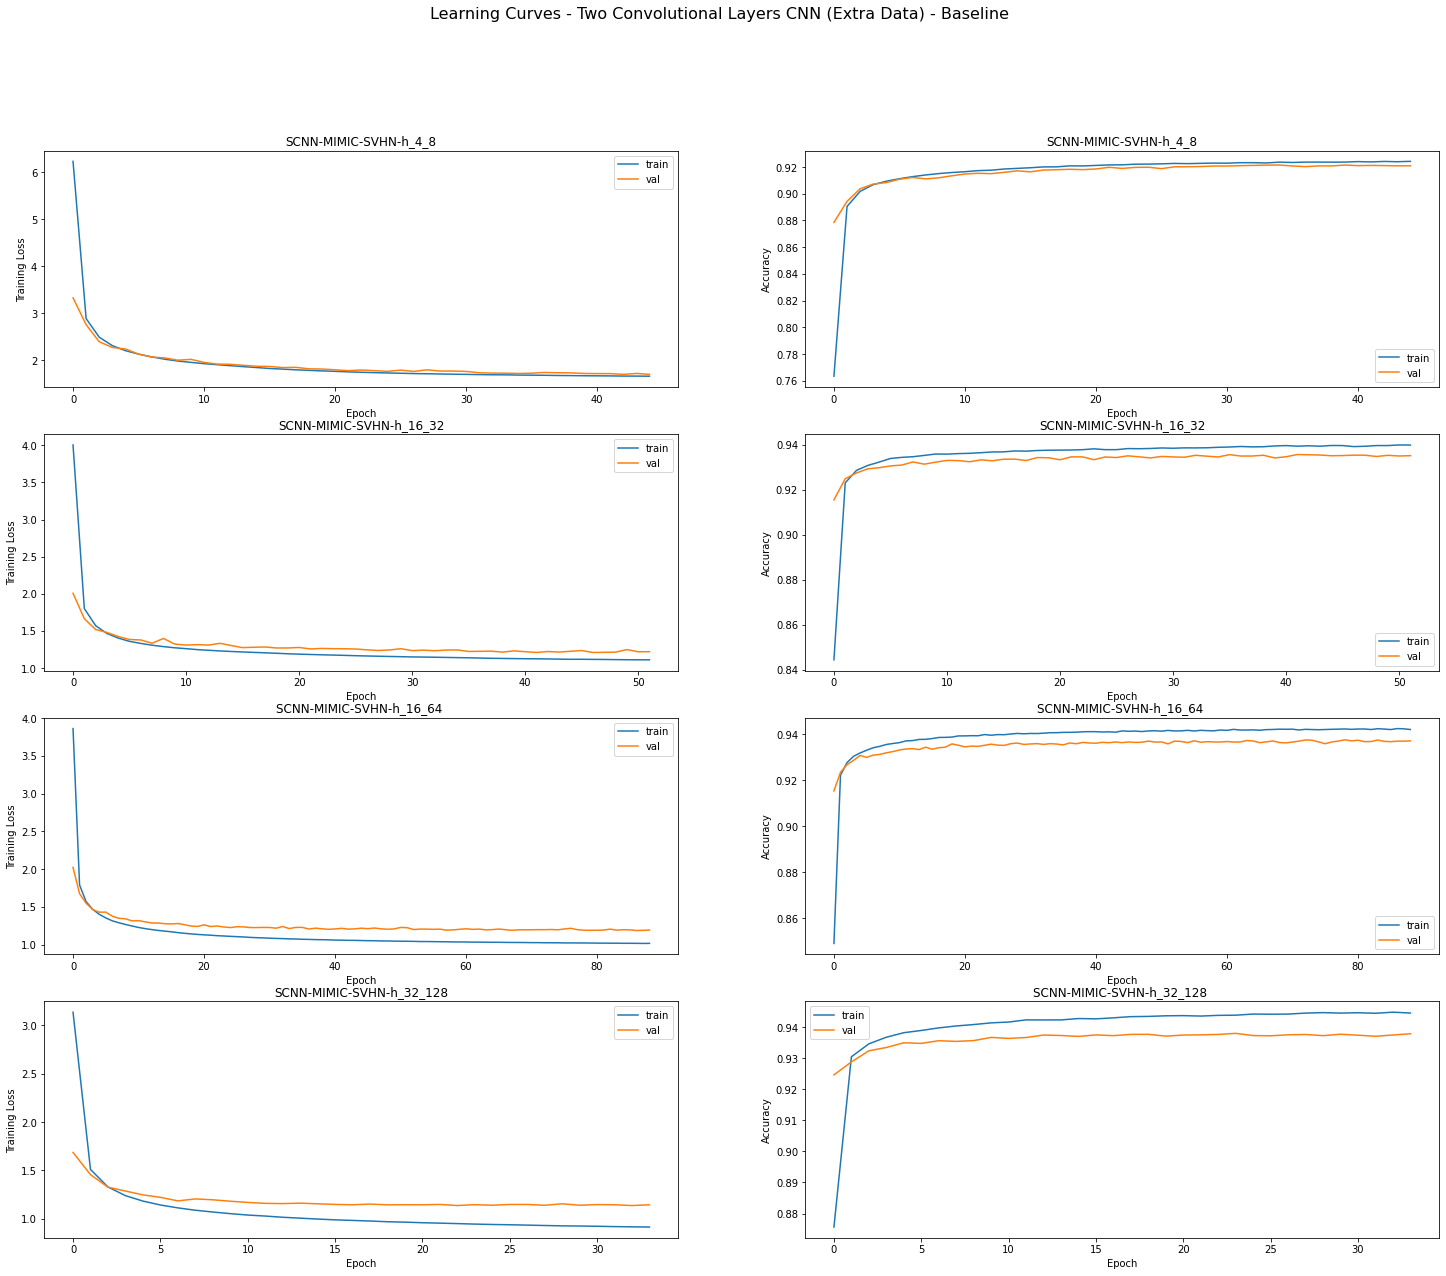

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Baseline', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_4_8, label='train');
plt.plot(loss_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_4_8, label='train');
plt.plot(acc_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16_32, label='train');
plt.plot(loss_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16_32, label='train');
plt.plot(acc_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_16_64 , label='train');
plt.plot(loss_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_16_64 , label='train');
plt.plot(acc_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_32_128, label='train');
plt.plot(loss_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_32_128, label='train');
plt.plot(acc_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Baseline_78


In [ ]:
loss_train_4_8=[2.113209612308309, 0.6925603452795471, 0.5475280576928977, 0.49262141829579487, 0.4652872451954744, 0.44777246520593456, 0.4359769624452474, 0.42653583994362965, 0.4182999165906806, 0.41127227503666286, 0.4053740349544555, 0.400026477696996, 0.3943956870904602, 0.3885492167289154, 0.3830468316456196, 0.3780002220899791, 0.37290679559515877, 0.3691317146560566, 0.3655754348467845, 0.3627242694860473, 0.35959191055001855, 0.3579008944969882, 0.35557329011547445, 0.3535730612585923, 0.352012113015855, 0.3500721209566076, 0.3483885727512626, 0.3469870360014594, 0.3455023366725813, 0.34423720970127863, 0.34312065150475474, 0.34175687420371115, 0.3411162686059999, 0.3398860340796186, 0.33900267029514247, 0.3378246042652921, 0.33753177897593883, 0.33670025557964706, 0.3359635321414749, 0.3352528200909416, 0.3345995859037451, 0.3341751285926266, 0.3334704867824515, 0.3330575889624714, 0.3323606421183335, 0.3321304946833149, 0.33175851539642304, 0.3312542033838978, 0.33099069180260193, 0.3303839373876524, 0.329913317010845, 0.32979758592439984, 0.32911309719842075]
loss_test_4_8=[0.832992586296628, 0.5927415542540952, 0.5039434843090422, 0.473852842522115, 0.4629746983746331, 0.4478062197348744, 0.44772594882791333, 0.4201086998909982, 0.43173296733979044, 0.4088808892729394, 0.42234318049997643, 0.40586907570079767, 0.392541121017261, 0.39130483975091934, 0.38479984666505596, 0.38847962191534313, 0.3772043472731185, 0.3772659890922291, 0.36851503123698576, 0.3679533517014372, 0.36386380773770444, 0.360133401686155, 0.35739002166274725, 0.35817529194719305, 0.36214530105456244, 0.36161708904983436, 0.3598842372616158, 0.3551994943462899, 0.34925942699374835, 0.3758255041342381, 0.3464746168235634, 0.34725735725283624, 0.34410676821107233, 0.34583283523899755, 0.3478254469484645, 0.3449601898991073, 0.34495234177465783, 0.34680387941622787, 0.34247077074341065, 0.342939825543318, 0.34367320880251623, 0.34370867367501223, 0.3426514100215175, 0.34250234009267333, 0.33633342728857474, 0.3389810599981535, 0.3375580345826153, 0.33812800050651515, 0.3361324693570358, 0.34188535938543313, 0.3400154032978633, 0.34361035185569155, 0.33878636115217475]
acc_train_4_8=[0.7827368, 0.895254, 0.906673, 0.91170007, 0.91393584, 0.9160352, 0.9164941, 0.9173601, 0.91831094, 0.91864514, 0.91977245, 0.92025256, 0.92053735, 0.9210669, 0.92190236, 0.9221471, 0.9226296, 0.9230956, 0.9234792, 0.923611, 0.92429346, 0.9248136, 0.9244253, 0.9245924, 0.92486304, 0.92491007, 0.925136, 0.9255832, 0.9254161, 0.9256067, 0.9257338, 0.9259315, 0.92631745, 0.92617625, 0.92627984, 0.9264846, 0.9264916, 0.92650104, 0.9268423, 0.9265811, 0.9269482, 0.9267858, 0.92669874, 0.92683756, 0.92703295, 0.92694116, 0.9272518, 0.9270588, 0.9273342, 0.9269882, 0.9271365, 0.9271506, 0.9273483]
acc_test_4_8=[0.8846150040626526, 0.903386116027832, 0.9103617668151855, 0.913986086845398, 0.9148144721984863, 0.9160571098327637, 0.9157464504241943, 0.9182034730911255, 0.9181187748908997, 0.9195308089256287, 0.9167913794517517, 0.9200674295425415, 0.9208487272262573, 0.9217618703842163, 0.9220255017280579, 0.9210276007652283, 0.9226844310760498, 0.9229856729507446, 0.9238705635070801, 0.9237387776374817, 0.9238705635070801, 0.9243035912513733, 0.9247366786003113, 0.9246142506599426, 0.9243318438529968, 0.9239364862442017, 0.92426598072052, 0.92496258020401, 0.9255744814872742, 0.9226844310760498, 0.9256685972213745, 0.9249531626701355, 0.9258474707603455, 0.9256874322891235, 0.9260828495025635, 0.9254050254821777, 0.9259792566299438, 0.9256309866905212, 0.9260922074317932, 0.9262428283691406, 0.9261958003044128, 0.925696849822998, 0.9266194105148315, 0.9257909655570984, 0.9259886741638184, 0.9260263442993164, 0.92655348777771, 0.9263558387756348, 0.9261769652366638, 0.9263464212417603, 0.9258663058280945, 0.9254426956176758, 0.9256309866905212]

loss_train_16_32=[1.1742873228389918, 0.40027239514371754, 0.35645958217717955, 0.3349655781732345, 0.321414808652591, 0.3115682967599554, 0.3035485304301072, 0.29600464350374195, 0.2900833916884528, 0.2857277910854327, 0.2822256573124624, 0.2791458194020117, 0.27673502310370107, 0.2745929635199745, 0.27228016284634654, 0.2698426817130879, 0.2677154723822991, 0.26628229035099965, 0.2647281401440808, 0.2636007268484734, 0.26251714375427876, 0.2611992652134596, 0.26025214075543907, 0.25908740916433576, 0.2584924865350967, 0.2575526500362984, 0.25686099470495527, 0.2560667967414994, 0.25519769830578765, 0.25459291829736164, 0.25424097112011895, 0.25331743927421935, 0.2527609851576102, 0.25210816018660576, 0.2516656641056709, 0.25101102089364774, 0.2504763295586605, 0.2501634675377815, 0.24941884731574412, 0.24914399042186616, 0.24875599767376533, 0.24831167203334842, 0.24809849712305193, 0.24722551521349892, 0.24710254256783623, 0.24688425006999415, 0.24639655942113403, 0.24606519366612223, 0.24559817190697777, 0.2457587588724001, 0.24545072067383847, 0.24481648666850414, 0.24451882902008107, 0.244300423465258, 0.24390321322631467, 0.2438064946931211, 0.24344441579714818, 0.24302756116659696, 0.24276574544338278, 0.24285648395679713, 0.2424750853494513, 0.24208013041961704, 0.2420159792050787, 0.24165177055405607, 0.24145379532868888, 0.24128652775408604, 0.24101212889002643, 0.24108829544588337, 0.24084012516371342, 0.24047443109167305, 0.24072440420729727, 0.23991416960170794, 0.24024377850496137, 0.23975001511290453, 0.23930337617221029]
loss_test_16_32=[0.4443595605514009, 0.3742495798876217, 0.3440203806814907, 0.33261849234312146, 0.3199430225027382, 0.3185328482917754, 0.3048625907408822, 0.30667087122260284, 0.2953825571218152, 0.29795496988825293, 0.2886685713523426, 0.2846401766503259, 0.291854526852195, 0.2812340334695365, 0.2785482362496418, 0.28547451210846575, 0.27492237211421766, 0.28458352464201764, 0.2762137172396125, 0.2752517158526804, 0.27195065677695107, 0.2757996480959629, 0.2703294025630911, 0.27472041219037185, 0.26860870111075813, 0.2692711134055305, 0.27012975423190166, 0.27044742797462396, 0.26846665131902886, 0.2671778367214332, 0.2689621869789886, 0.26804981052685306, 0.2642880070135381, 0.2679250386149053, 0.26419083849740976, 0.2656462110395041, 0.2630816801439951, 0.26843250108435496, 0.2640867416609452, 0.2718488151806705, 0.26365661626031484, 0.2702956036930764, 0.2598652429793494, 0.2625197840194296, 0.26190297793479955, 0.2620633551262893, 0.26474664205216053, 0.2574992172226934, 0.25769311612529294, 0.2655706902439007, 0.25940864531032715, 0.26011551232722846, 0.2620905960392673, 0.2576428134966212, 0.25545988093297073, 0.26541917094063056, 0.25718977983222424, 0.2622769024065524, 0.26038335580880434, 0.2603341831299382, 0.2563536490259273, 0.26212821970225375, 0.25804705556889546, 0.2563274617768389, 0.25372512856208007, 0.25685356816852867, 0.25774297776084154, 0.2560121388555418, 0.256339131442228, 0.2526235606765835, 0.2536417058236514, 0.2531120552590794, 0.26498108011037563, 0.2598996368964814, 0.2538835831769313]
acc_train_16_32=[0.8592294, 0.9198431, 0.9242017, 0.9259174, 0.92735773, 0.928758, 0.9292993, 0.9301207, 0.93102443, 0.9313139, 0.93165046, 0.93221295, 0.9325071, 0.9325612, 0.93334496, 0.9335403, 0.9337427, 0.93386036, 0.9337968, 0.93423456, 0.93456405, 0.934364, 0.9344487, 0.93465817, 0.93455464, 0.9346158, 0.93488175, 0.9348135, 0.93518066, 0.93521595, 0.9352371, 0.93534774, 0.93521124, 0.93540424, 0.935609, 0.9356796, 0.9357902, 0.9353784, 0.9357643, 0.9357031, 0.9359502, 0.9357172, 0.9360985, 0.93607265, 0.9358208, 0.93600905, 0.9362609, 0.9364633, 0.93606085, 0.93615735, 0.9362303, 0.9363174, 0.9364703, 0.9364139, 0.93644917, 0.936428, 0.9366445, 0.93643504, 0.9361903, 0.936934, 0.9368516, 0.9363739, 0.93690574, 0.9366916, 0.9370187, 0.9368728, 0.9368916, 0.93696225, 0.93690574, 0.93705875, 0.9369246, 0.93686104, 0.93729645, 0.9369363, 0.93671983]
acc_test_16_32=[0.9182975888252258, 0.9233904480934143, 0.926628828048706, 0.9274477958679199, 0.9283139109611511, 0.9291422963142395, 0.9307426810264587, 0.9314863681793213, 0.9313545227050781, 0.9316840171813965, 0.9325971603393555, 0.9329737424850464, 0.9333314299583435, 0.9331149458885193, 0.9331808090209961, 0.9330961108207703, 0.9339810013771057, 0.9330584406852722, 0.9332278966903687, 0.9340469241142273, 0.9339904189109802, 0.9331526160240173, 0.9348658919334412, 0.9338680505752563, 0.9349412322044373, 0.9341033697128296, 0.9347246885299683, 0.9343387484550476, 0.9353365898132324, 0.9353365898132324, 0.9345552325248718, 0.9350730180740356, 0.9358543753623962, 0.9352613091468811, 0.9359390735626221, 0.9348941445350647, 0.9354119300842285, 0.9358731508255005, 0.9352989196777344, 0.9349976778030396, 0.9360237717628479, 0.9345929026603699, 0.9357507824897766, 0.9354966282844543, 0.9355248808860779, 0.9348658919334412, 0.936136782169342, 0.9360708594322205, 0.9358261227607727, 0.9356284141540527, 0.9351106882095337, 0.9365227222442627, 0.9364003539085388, 0.9361650347709656, 0.9367204308509827, 0.9356284141540527, 0.9356755018234253, 0.9362685680389404, 0.936099112033844, 0.9361085295677185, 0.9366074800491333, 0.9357319474220276, 0.9363532662391663, 0.9359861612319946, 0.9371628761291504, 0.9366262555122375, 0.9358637928962708, 0.9356001615524292, 0.9366262555122375, 0.9371534585952759, 0.9367204308509827, 0.9365038871765137, 0.9354683756828308, 0.936296820640564, 0.9361273646354675]

loss_train_16_64=[0.8763782706260995, 0.33246783174909217, 0.2927485933046934, 0.2719912511224099, 0.2589585093556101, 0.24944484626381846, 0.24235584345594774, 0.23605809999441918, 0.23119525129433763, 0.22700458486634367, 0.22361267869335547, 0.220177732387987, 0.2173707494353511, 0.2146162630915204, 0.2120264434856873, 0.20991218974172923, 0.20791353158220865, 0.20592470659074955, 0.20459179949900042, 0.2031357612767289, 0.20133097730106359, 0.20014793401095476, 0.1992827009380839, 0.19786519457878782, 0.1973671142695806, 0.19644062045310098, 0.1956521245700693, 0.19464575713514584, 0.19405233139885195, 0.19324002527290365, 0.192747896338446, 0.19217411628038894, 0.1915398384048218, 0.19073428402887355, 0.19034871592579888, 0.19014561746305306, 0.1897310635899702, 0.18906086214997597, 0.1887443489661347, 0.18861015397522468, 0.18818968535086827, 0.18764369517428423, 0.18742990296655895, 0.18686451429151427, 0.18674891535836252, 0.18640524648526785, 0.18596783206810885, 0.18585105835824725, 0.18562844607288823, 0.185145567053109, 0.18498490919684246]
loss_test_16_64=[0.35880201409901497, 0.30652639621923033, 0.285575571910773, 0.271617355593241, 0.2608975849407633, 0.2538504142396994, 0.24955777143793978, 0.24098950134970787, 0.24143741337052277, 0.23780634888667118, 0.2412889366099313, 0.23214700245270434, 0.23105451026695478, 0.2304500774383305, 0.22685203368795176, 0.23164684082588746, 0.22644472478915748, 0.2275226568216116, 0.2286898518691129, 0.22153838504568474, 0.2257458725401028, 0.21569535239227938, 0.2188206540713356, 0.2198382290595794, 0.22726787071374274, 0.21753890910758947, 0.22015600352327713, 0.21673919863747304, 0.21477558918104622, 0.2138061209644382, 0.21831352309889135, 0.22018736385425042, 0.21610251252690962, 0.21142452778848161, 0.21369864505881273, 0.2126180998578335, 0.2118610799283414, 0.2138229702790412, 0.21134518752200027, 0.21431966807372677, 0.20835491615489446, 0.21084754228717045, 0.2101909273770649, 0.21718291381589203, 0.2146690467724929, 0.21411185158546717, 0.2089510513014993, 0.21051709005504807, 0.20729801219680502, 0.21064798382726366, 0.21083954600623514]
acc_train_16_64=[0.88259935, 0.92656225, 0.93066436, 0.93318963, 0.93433106, 0.9356561, 0.93620443, 0.9371058, 0.93756706, 0.9386261, 0.9388638, 0.939384, 0.9398005, 0.9401041, 0.94024533, 0.94049245, 0.940789, 0.9411773, 0.94125026, 0.94155854, 0.9411373, 0.942121, 0.9418339, 0.9423517, 0.9421987, 0.9424835, 0.9424011, 0.9424435, 0.94274944, 0.94302946, 0.9428059, 0.94284594, 0.94301534, 0.9430883, 0.94311655, 0.94313776, 0.94340605, 0.9435331, 0.9434343, 0.9435496, 0.9435143, 0.9435637, 0.94349545, 0.94360137, 0.9438673, 0.94387203, 0.94384146, 0.943792, 0.94359195, 0.9437096, 0.9439426]
acc_test_16_64=[0.924228310585022, 0.9290010929107666, 0.93171226978302, 0.9336891770362854, 0.9345834851264954, 0.9358167052268982, 0.9359955787658691, 0.9373323321342468, 0.9367486834526062, 0.9386879205703735, 0.9378312230110168, 0.9383584260940552, 0.9391021132469177, 0.9393845200538635, 0.9390361905097961, 0.9382548928260803, 0.9392150640487671, 0.9398458003997803, 0.93935626745224, 0.9396292567253113, 0.93955397605896, 0.9411261081695557, 0.9409472346305847, 0.9407024383544922, 0.9410696029663086, 0.9414273500442505, 0.941022515296936, 0.9413331747055054, 0.9414649605751038, 0.9410413503646851, 0.9412484765052795, 0.9401564598083496, 0.9407871961593628, 0.9414367079734802, 0.9408530592918396, 0.9417944550514221, 0.9422463178634644, 0.9417285919189453, 0.9418227076530457, 0.9418697953224182, 0.9429994225502014, 0.9416438341140747, 0.9423969388008118, 0.9417756199836731, 0.9418603777885437, 0.9423310160636902, 0.942171037197113, 0.942114531993866, 0.9426605105400085, 0.9418415427207947, 0.9420768618583679]

loss_train_32_128=[0.9079667797261535, 0.34226699262358606, 0.3013925068515988, 0.2797465022265683, 0.2642790156875672, 0.2522991034332824, 0.2436840324029008, 0.2375041929592853, 0.2319946438029223, 0.2280898856290294, 0.2243088748004228, 0.2209845319705361, 0.2184084496583195, 0.2156774126706004, 0.21345406119451954, 0.2114576000106617, 0.20995594739224896, 0.2081497124144343, 0.20618748361462894, 0.2050384909546939, 0.20319460116505944, 0.20253493722065372, 0.20118173908587375, 0.19998174984023995, 0.19918469057075408, 0.1984271406633602, 0.19768411134992558, 0.19652569520721042, 0.19600923031845155, 0.1951260286301496, 0.19458786554848775, 0.1939108446996523, 0.19316949813560932, 0.1926742669683735, 0.1923955349982511, 0.19159704417530632, 0.19120475467304063, 0.1908323967575549, 0.19046481976712126, 0.18980869163936137, 0.18935145691171565, 0.18936665715775658]
loss_test_32_128=[0.38054436949446374, 0.3245727074006892, 0.3026282493550155, 0.2817183534691464, 0.27079012101766503, 0.27320402455859355, 0.25840756560424694, 0.25331616225541076, 0.24866409485217147, 0.24348058378736168, 0.24523097134138552, 0.24028432936693062, 0.24254421006502355, 0.2346386521753358, 0.23561861837776707, 0.2335014198118935, 0.2382045875890496, 0.23287200102178596, 0.24363856710878554, 0.2340413255970993, 0.23388123292258264, 0.2337873349507726, 0.22769205331576803, 0.23520632188440035, 0.22584915782908793, 0.23343295579715692, 0.22456599619594012, 0.2293843712181416, 0.2317702346155985, 0.23014265392197453, 0.2289328165940454, 0.2227871027424356, 0.2301557359062271, 0.22813011852941373, 0.22342356192854332, 0.2280853635452465, 0.22579811537733852, 0.22765527528789298, 0.22512055649457485, 0.22676979026630747, 0.2232530085129002, 0.2293155549618768]
acc_train_32_128=[0.8803306, 0.92534786, 0.9295629, 0.93187875, 0.93338495, 0.93503237, 0.9358985, 0.9367504, 0.93727994, 0.93771535, 0.9385791, 0.939158, 0.93960756, 0.939584, 0.9399511, 0.94044775, 0.9405113, 0.94081014, 0.940982, 0.94101727, 0.94109493, 0.94129735, 0.94157034, 0.94144326, 0.9415915, 0.9421022, 0.9417351, 0.9421564, 0.94237053, 0.94229287, 0.9426835, 0.9426835, 0.94274944, 0.9427212, 0.94275886, 0.94307894, 0.9429659, 0.9430601, 0.9431989, 0.94322956, 0.94302475, 0.9431495]
acc_test_32_128=[0.9221101999282837, 0.9269583225250244, 0.9291046261787415, 0.9327007532119751, 0.9319758415222168, 0.9339998364448547, 0.9347152709960938, 0.9365133047103882, 0.936136782169342, 0.9368239641189575, 0.9364568591117859, 0.9368616342544556, 0.9372381567955017, 0.9376429915428162, 0.9373981952667236, 0.9381136894226074, 0.937012255191803, 0.9381701350212097, 0.9378688931465149, 0.9378124475479126, 0.9394504427909851, 0.937944233417511, 0.9393280148506165, 0.9396198987960815, 0.9394127726554871, 0.9398834705352783, 0.9397234320640564, 0.9384713768959045, 0.9396669268608093, 0.9391115307807922, 0.9389138221740723, 0.9403353333473206, 0.9392150640487671, 0.9395068883895874, 0.9396669268608093, 0.9396669268608093, 0.9396857619285583, 0.9392338991165161, 0.9392621517181396, 0.9387820363044739, 0.9397045969963074, 0.9390738606452942]


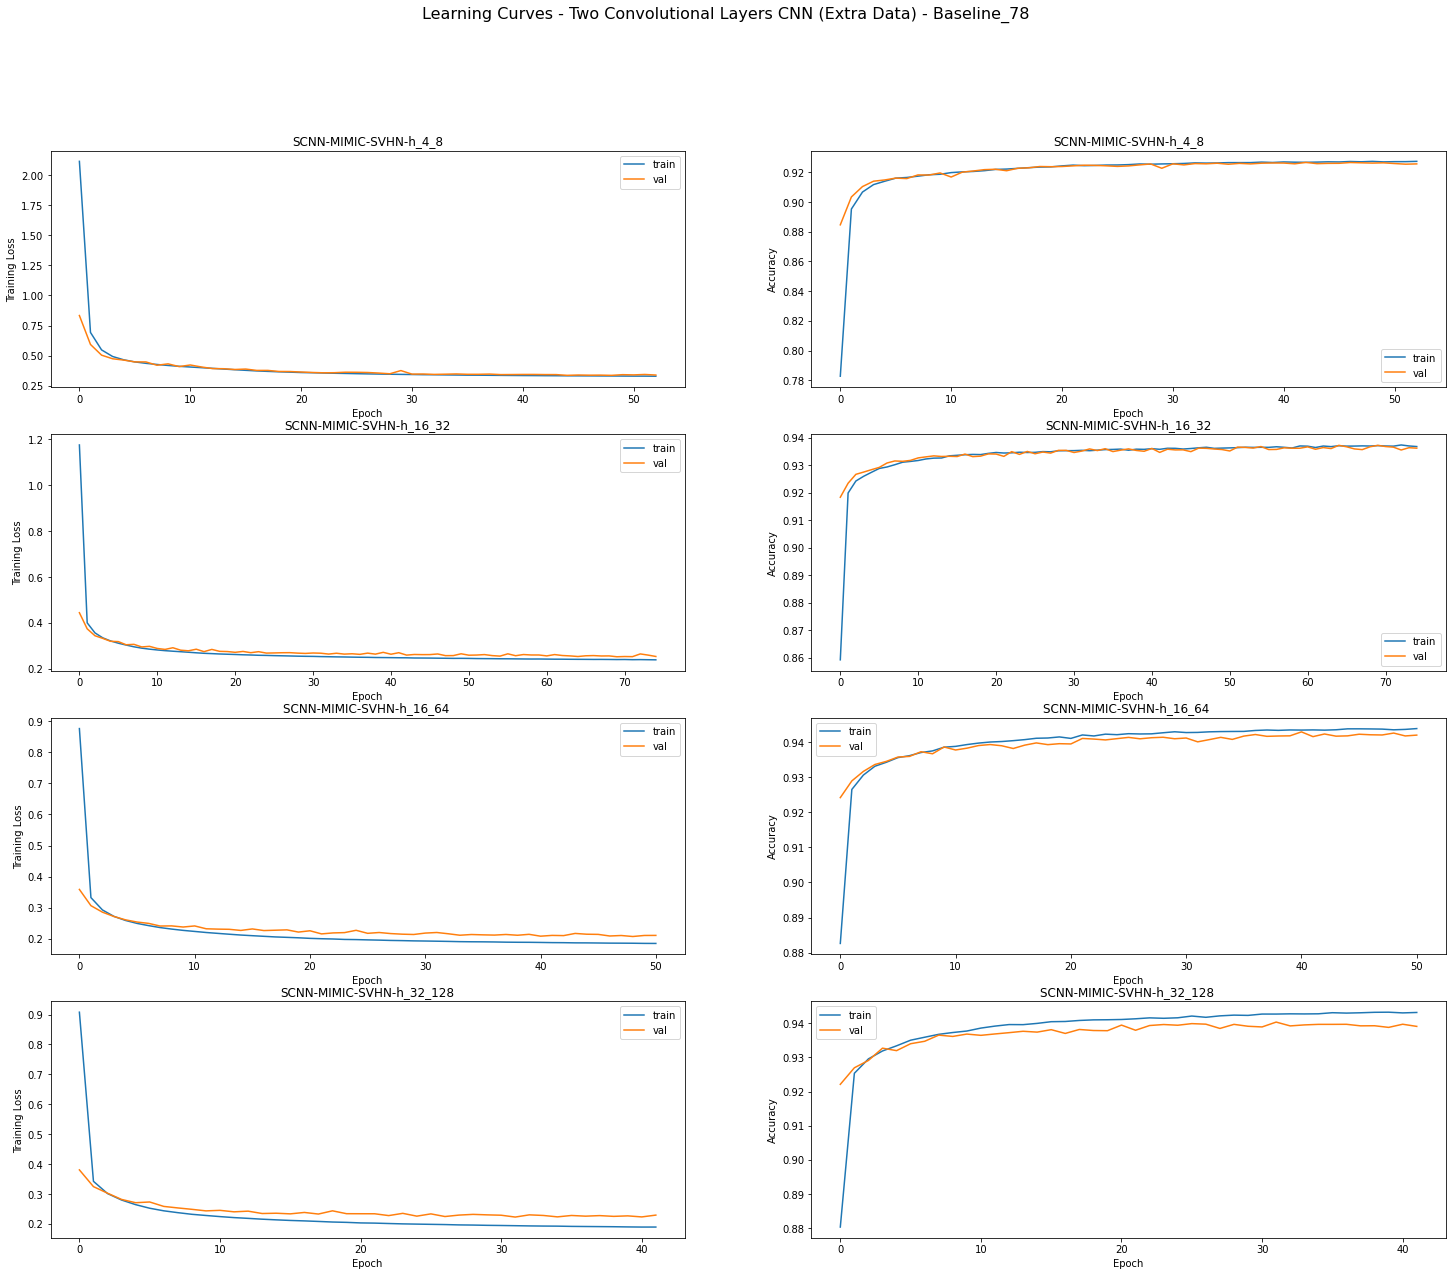

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Baseline_78', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_4_8, label='train');
plt.plot(loss_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_4_8, label='train');
plt.plot(acc_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16_32, label='train');
plt.plot(loss_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16_32, label='train');
plt.plot(acc_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_16_64 , label='train');
plt.plot(loss_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_16_64 , label='train');
plt.plot(acc_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_32_128, label='train');
plt.plot(loss_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_32_128, label='train');
plt.plot(acc_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Robust


In [ ]:
loss_train_4_8=[0.502888107659814, 0.16353751530520558, 0.12587023341754264, 0.10913667270267986, 0.09866372543514014, 0.09173657055011707, 0.08576553881534771, 0.08066229018932145, 0.07685856359810013, 0.07420925756501637, 0.07208692631351522, 0.07060485043404137, 0.06911628801089671, 0.06791616370590224, 0.06688736077184348, 0.06558472431453088, 0.06470781710587523, 0.06398760286108383, 0.06306696552190927, 0.06257483090549489, 0.06188403987109963, 0.06104252448886694, 0.06048302962917897, 0.05991547196363394, 0.05918967853926141, 0.05849376705922831, 0.05781037472750286, 0.05716533120758401, 0.056490013902306256, 0.05597597984567103, 0.05537221113302727, 0.05485853750497928, 0.05442908402596376, 0.05399975263922938, 0.05360168049963555, 0.0531536358468476, 0.05282969722862741, 0.05257484233072941, 0.05228237892429462, 0.05196190593628151, 0.051790992621018675, 0.05143189659717448, 0.05137003092682494, 0.05101633182543615, 0.050861146554653576, 0.050708839165559634, 0.05057410936280581, 0.05029080526197078, 0.05017454391570002, 0.05010840499334657, 0.04993541180726138, 0.04971286702980452, 0.04957795019984479, 0.04918986021425347, 0.0489365757976891, 0.04856765401308833, 0.048243192520463996, 0.04806515638344835, 0.047900398639525846, 0.04769545990665871, 0.04748650537720128, 0.047313253769678654, 0.04712812044873216, 0.04692989760725434, 0.046802199581962405, 0.04671645985178641, 0.04650029568412116, 0.046296403805171686, 0.04604260536082952, 0.04590697662798493, 0.0456006724872839, 0.04533552368617649, 0.04507326119774063, 0.0447691518794364, 0.044343900887409825, 0.04406720708159356, 0.0437277307908855, 0.043365659334972315, 0.04296684634151787, 0.04281489038365622, 0.04246020051587666, 0.04205960453878309, 0.04174663176442664, 0.041394707676016024, 0.04105297594055015, 0.04074799613665751, 0.04033905274006919, 0.03984443275519739, 0.03953784037144832, 0.039162704828651265, 0.03894170535593984, 0.038752799330621264, 0.03857378376749146, 0.03841284076270753, 0.038257409607545104, 0.03806705425892317, 0.037958542799384834, 0.03783409234832191, 0.03768155955387983, 0.037540976241189725, 0.03747729979225556, 0.03725307926415248, 0.03724328756602853, 0.03707609857097227, 0.037031457182669786, 0.03686140427297549, 0.03680038347339797, 0.03659365740841681, 0.036538800291960154, 0.03657663565344298, 0.03635599010428146, 0.03639185881969532, 0.03623867762856264, 0.03614910315933556, 0.03611002015153847, 0.03604719589153458, 0.03590892807685581, 0.036013549344328225, 0.03589061515988734, 0.035818193377106844, 0.03576477076955425, 0.035777209626012996, 0.035589902948977334, 0.03560560468426557, 0.03552775599013766, 0.03550166904790511, 0.03540938874398751, 0.035458479940104586, 0.035278446913628775, 0.03529288516561255]
loss_test_4_8=[0.1931184602170972, 0.13333791234563236, 0.11661013522263564, 0.09819346841443326, 0.09697993953419817, 0.08603517207296074, 0.08006112837379703, 0.07953153400136123, 0.075188543360627, 0.07086601698912115, 0.07023732653799764, 0.07065180307109271, 0.0674170772929529, 0.0668599953071003, 0.06634836919521636, 0.06440078942219411, 0.06428106057972081, 0.06366059415460636, 0.06493885086280457, 0.061830815549346885, 0.06011067500144079, 0.06408461233879266, 0.06193800054769927, 0.05946504177152732, 0.06090580150568503, 0.059338090402945916, 0.0579382670210367, 0.060934766811309514, 0.056495023233099406, 0.05564094685283256, 0.056816861634209195, 0.05489979252469313, 0.058209164629331935, 0.053072201419456774, 0.05472010733464848, 0.055093160527256595, 0.054599443212678546, 0.05231730378806163, 0.053687450949222615, 0.052597284399849925, 0.05125997543220075, 0.05820477120188671, 0.051336574055458495, 0.05102975763643476, 0.05552350488841987, 0.04959245780284134, 0.04981666926340471, 0.049163297684906085, 0.04982167254289872, 0.05093977094112935, 0.050339413857067694, 0.05120930404215301, 0.05091251707771143, 0.05086453038045093, 0.050800155991907923, 0.04917158451246337, 0.04930493405242087, 0.04946257146341981, 0.05097285564784574, 0.04792339824175071, 0.04734440823041989, 0.04802902458228239, 0.046497483180702105, 0.04834901596007512, 0.04670156207612584, 0.04561494496856438, 0.04863706645823942, 0.04802439095965507, 0.04660395998038688, 0.04655445522194665, 0.045391518968874486, 0.04415791310420538, 0.043954278723618685, 0.04427394425085431, 0.04382676978779045, 0.04256308769561437, 0.04359447266232997, 0.044941332946723506, 0.042806630390532584, 0.04283134092037166, 0.0411149570120917, 0.04200718326639056, 0.04188567169441078, 0.04256881303945048, 0.04032255303652719, 0.039934499973842116, 0.03944264622213781, 0.039516354896572084, 0.03957980464626404, 0.03981104281376129, 0.03870264287298302, 0.04008352894556956, 0.03930478601812013, 0.03798530753426808, 0.03932564745248932, 0.03918848420400573, 0.03825588828983758, 0.039293297428029256, 0.037811481292883316, 0.037300122724645494, 0.037545798753886216, 0.04137841186494417, 0.03964896491816773, 0.03860289642331878, 0.0379621369721477, 0.03724101784281697, 0.03743091234931436, 0.03603270004862107, 0.03682377996857912, 0.036691688204556906, 0.03956464950413619, 0.037940840432028736, 0.03541353556384255, 0.036776547476253564, 0.036419520026084486, 0.03892228676968969, 0.03834846556566545, 0.03670273725380817, 0.036812564487081985, 0.0356162078730861, 0.03897196789504436, 0.03844794465523549, 0.036022104061855575, 0.03577080156343372, 0.03624683856103935, 0.03837228581466849, 0.03836889645502745, 0.03560890150860565, 0.0366300797577378, 0.03672418576183311]
acc_train_4_8=[0.82796115, 0.9110199, 0.92181057, 0.92758363, 0.93164337, 0.9338415, 0.93598557, 0.9379554, 0.94005704, 0.9412644, 0.9420622, 0.9426247, 0.94345546, 0.94424623, 0.9447499, 0.9453194, 0.94584423, 0.9460043, 0.94599485, 0.9464773, 0.94666797, 0.9471857, 0.94745165, 0.947767, 0.9478, 0.94824475, 0.94891316, 0.94956505, 0.9495463, 0.9495745, 0.9501864, 0.9500193, 0.95085007, 0.9508336, 0.95113486, 0.9511443, 0.9514785, 0.9514761, 0.9517985, 0.95187145, 0.95211154, 0.9519868, 0.9522269, 0.9523728, 0.95264107, 0.9526505, 0.9526175, 0.9527446, 0.9530294, 0.952794, 0.9532694, 0.9529753, 0.952827, 0.9531847, 0.95333534, 0.9533518, 0.9535448, 0.9533636, 0.9537472, 0.953606, 0.95414495, 0.9540555, 0.95386255, 0.9540767, 0.95400375, 0.9543285, 0.95418257, 0.95428616, 0.9543921, 0.95455915, 0.9548086, 0.954698, 0.95506513, 0.9551828, 0.9554205, 0.95601594, 0.9559877, 0.95591, 0.9566255, 0.95629835, 0.95657843, 0.95681614, 0.95678085, 0.9574092, 0.95739037, 0.9577528, 0.95779514, 0.9585883, 0.9585859, 0.9587742, 0.9587554, 0.9591508, 0.9591014, 0.9592002, 0.959099, 0.959252, 0.9594332, 0.9592943, 0.959605, 0.9595767, 0.9596403, 0.9598003, 0.96011335, 0.9595767, 0.95972264, 0.96021456, 0.96007335, 0.9601557, 0.96039575, 0.9601039, 0.9599086, 0.96034163, 0.9601769, 0.96041226, 0.96038634, 0.9604593, 0.9606523, 0.9606546, 0.96045226, 0.960271, 0.9607959, 0.9607182, 0.9609441, 0.9605652, 0.96072286, 0.96058166, 0.9606429, 0.96101475, 0.9609865, 0.96091825]
acc_test_4_8=[0.9035273790359497, 0.9195496439933777, 0.9245954155921936, 0.9313921928405762, 0.932427704334259, 0.9370781183242798, 0.9371063709259033, 0.9361556172370911, 0.9415685534477234, 0.9421616196632385, 0.943978488445282, 0.9431594610214233, 0.9445527195930481, 0.9445715546607971, 0.9438184499740601, 0.945371687412262, 0.9454564452171326, 0.9455693960189819, 0.9444020986557007, 0.9457388520240784, 0.9478004574775696, 0.9443926811218262, 0.9449386596679688, 0.9485064744949341, 0.946360170841217, 0.9466614127159119, 0.9479416608810425, 0.9485347270965576, 0.9481205344200134, 0.9506999254226685, 0.9477157592773438, 0.9509446620941162, 0.948685348033905, 0.9512741565704346, 0.949833869934082, 0.9511047005653381, 0.9509917497634888, 0.9510388374328613, 0.9501727223396301, 0.9508128762245178, 0.9525262117385864, 0.948666512966156, 0.9513965249061584, 0.9522155523300171, 0.9504457712173462, 0.953034520149231, 0.9524791240692139, 0.9533828496932983, 0.9531851410865784, 0.9521026015281677, 0.9530816078186035, 0.9506340026855469, 0.9515565633773804, 0.9512741565704346, 0.9526297450065613, 0.9531945586204529, 0.9538158774375916, 0.952375590801239, 0.9501162767410278, 0.954004168510437, 0.954700767993927, 0.9542394876480103, 0.9548137187957764, 0.9531475305557251, 0.9542489051818848, 0.9561128616333008, 0.9534958004951477, 0.9533451795578003, 0.9546443223953247, 0.9551526308059692, 0.9537782073020935, 0.9550679326057434, 0.9550773501396179, 0.9548419713973999, 0.9557268619537354, 0.9562823176383972, 0.9567153453826904, 0.9545878171920776, 0.9567341804504395, 0.9555103778839111, 0.9576002359390259, 0.9573084115982056, 0.9579485654830933, 0.9568471312522888, 0.957459032535553, 0.9578261375427246, 0.9591158628463745, 0.958136796951294, 0.9590217471122742, 0.9579674005508423, 0.9592947363853455, 0.9588617086410522, 0.9595865607261658, 0.9599254131317139, 0.958155632019043, 0.9586169123649597, 0.9599348306655884, 0.9602454900741577, 0.9600854516029358, 0.9601419568061829, 0.9599819183349609, 0.9556044936180115, 0.9570354223251343, 0.95930415391922, 0.9600760340690613, 0.9603208303451538, 0.9605655670166016, 0.9610174298286438, 0.9602549076080322, 0.9601702094078064, 0.9578073620796204, 0.9606785178184509, 0.961431622505188, 0.9594265222549438, 0.9599819183349609, 0.9585227966308594, 0.9577037692070007, 0.9606879353523254, 0.9604714512825012, 0.9616199135780334, 0.9584568738937378, 0.958136796951294, 0.9590593576431274, 0.9604431986808777, 0.9599536657333374, 0.9587769508361816, 0.9582968354225159, 0.9603961110115051, 0.9608291387557983, 0.9599630832672119]

loss_train_16_32=[0.3385513214024432, 0.07739962240788681, 0.056216882730204004, 0.04724184961075717, 0.042438297904603524, 0.03936742919155282, 0.03689920164579769, 0.034678359967151344, 0.03309649056388618, 0.03183751569835808, 0.03074975702321396, 0.02985874486218565, 0.028992390816337345, 0.028327904373416903, 0.027958298142316047, 0.027420826455890644, 0.027081468022333362, 0.026876731081623487, 0.026511684901132947, 0.026319592672329004, 0.026042345270194375, 0.02590340403170294, 0.025594321859304468, 0.025429182901080434, 0.02525353125155852, 0.02515789043889351, 0.024944264229628393, 0.0246902060140246, 0.024290203047870038, 0.024060242005650514, 0.023856566554087646, 0.02376947203715283, 0.023523783528643514, 0.023378763328891564, 0.023288617126148898, 0.023165387681187418, 0.023121550078922606, 0.02301864928834008, 0.02290132509022763, 0.02284462241590895, 0.022826988570902883, 0.022698071384584854, 0.022636973010867596, 0.022598505900139995, 0.02252812026839711, 0.022443323704214122, 0.022458925974223328, 0.022403481384964462, 0.022374728707884546, 0.022258896268826354, 0.022225453001249142]
loss_test_16_32=[0.09914603414291397, 0.06251379681319834, 0.04935681370104862, 0.047356238271402645, 0.04297822924929619, 0.03779465064113357, 0.03658854414246429, 0.033963043614390835, 0.033054750005865385, 0.03172738820353545, 0.02964478003684513, 0.030126787776432858, 0.03055741334628614, 0.0299485818905317, 0.029008167703157936, 0.02894690681753864, 0.026416649669731434, 0.02690538207775209, 0.02640641794930141, 0.028747993028644527, 0.02765255524380621, 0.026536006272600565, 0.025132566025989813, 0.025222779382188743, 0.02482938900874985, 0.026231719883236325, 0.02484201775219003, 0.024017870066894566, 0.026242069834351345, 0.02482776183240854, 0.023950521888700883, 0.023927118051435412, 0.024402930965273947, 0.02459260343576188, 0.024334473004927522, 0.02373145313875575, 0.024381662214069958, 0.023951138901711716, 0.023709096129824556, 0.024379220950015528, 0.02292158176233874, 0.02409647753345608, 0.023689756046208783, 0.023310677424720316, 0.023909047885570415, 0.022417644645597878, 0.02293309382831292, 0.022647094009892916, 0.02233701508094512, 0.02261765687459869, 0.022902254984465915]
acc_train_16_32=[0.8697847, 0.9408996, 0.9502099, 0.95419437, 0.9570209, 0.95874596, 0.9603134, 0.96190906, 0.9625821, 0.9633682, 0.96383417, 0.9644673, 0.9648956, 0.96563226, 0.9657499, 0.9664795, 0.96624887, 0.96634066, 0.9669078, 0.9667219, 0.96713376, 0.9672067, 0.96740913, 0.967435, 0.9676562, 0.96778095, 0.9677598, 0.9678892, 0.968407, 0.9681128, 0.96863055, 0.96835756, 0.96864706, 0.9685223, 0.9687647, 0.96881884, 0.96900004, 0.96888006, 0.9688377, 0.96890825, 0.96890354, 0.96887296, 0.9689836, 0.96910363, 0.96900475, 0.96910363, 0.96927303, 0.96928716, 0.9691601, 0.9695178, 0.96934134]
acc_test_16_32=[0.9289446473121643, 0.9451175332069397, 0.9529121518135071, 0.954917311668396, 0.9559904932975769, 0.9582215547561646, 0.9599536657333374, 0.9610833525657654, 0.9619117379188538, 0.9631167054176331, 0.9642369747161865, 0.9642181396484375, 0.9629190564155579, 0.9658278822898865, 0.9644440412521362, 0.9639639854431152, 0.9662232995033264, 0.965874969959259, 0.9663362503051758, 0.9647829532623291, 0.96585613489151, 0.9663645029067993, 0.9673623442649841, 0.9671928882598877, 0.9672588109970093, 0.9660914540290833, 0.9664868712425232, 0.9678895473480225, 0.9647829532623291, 0.9663268327713013, 0.9684637784957886, 0.9673435091972351, 0.9669387340545654, 0.966966986656189, 0.9664586186408997, 0.9681907892227173, 0.965639591217041, 0.9679177403450012, 0.9673152565956116, 0.9681060314178467, 0.9689626693725586, 0.9676918387413025, 0.9687461853027344, 0.9684637784957886, 0.9677106738090515, 0.968416690826416, 0.9688591361045837, 0.9689062237739563, 0.9683225750923157, 0.9678047895431519, 0.9685013890266418]

loss_train_16_64=[0.25795131061934745, 0.05230069553646378, 0.03763179342228026, 0.031699068285345994, 0.028426822861390193, 0.02625425074985895, 0.024838892933699265, 0.023586460479939144, 0.022844383011807398, 0.022146289189482256, 0.021555389129731484, 0.02104837998107878, 0.020510845819677086, 0.02023879192650852, 0.01986731432349956, 0.019595740847276236, 0.019279102038114383, 0.019022627671241688, 0.01881872831379631, 0.018623718541022447, 0.0183025354823644, 0.01819521978991564, 0.017989645987145062, 0.01785623172121569, 0.01768049251260751, 0.01759326640822536, 0.0173564384098971, 0.01730832485822446, 0.017128935142558425, 0.01707814498632406, 0.01696759173035133, 0.016918762931112573, 0.016735367091175905, 0.01672412588714183, 0.016668859759754805, 0.016571225478972766, 0.01647726162032802, 0.016453913466942575, 0.016280567445548438, 0.016303286193522556, 0.016224007583715394, 0.016194284783541846, 0.016078108956962035, 0.016085680669287117, 0.016054411138022348, 0.015941191609254005, 0.01590266661172491, 0.015847340711271946, 0.015804086247169346, 0.015747863776818968, 0.015750901241778414, 0.015700635499533322, 0.015616170184869948, 0.015599618225892342, 0.015599058644213674, 0.015592424187219291, 0.015503409990820134, 0.015471531115708686, 0.015393993027101874, 0.015416462473245716, 0.015406805296867344, 0.015320246807512374, 0.015291607636144958, 0.015297043093888922, 0.015253551955089584, 0.015196079990771997, 0.015157097091358006, 0.015149392619651328, 0.015128443302225845, 0.01510371439714908]
loss_test_16_64=[0.06600231837440546, 0.04130247540504945, 0.03453304127513242, 0.02912543187919844, 0.02579267985055988, 0.02794767064809571, 0.023894549017608638, 0.025590473867462066, 0.023871588197447068, 0.02281456001361945, 0.022113870959274987, 0.022133939602635086, 0.022562150803734443, 0.020367753430995474, 0.022328398522622476, 0.022564953295523018, 0.01995137476264699, 0.020424975004231863, 0.019642441023889838, 0.020107013812177103, 0.017830697975771016, 0.019084984742591977, 0.018417589429507865, 0.019992072573714655, 0.01860315901068581, 0.019677051787797002, 0.01824726170104587, 0.019066533391930224, 0.017697384430400427, 0.01802286742384339, 0.018461550051287662, 0.01852794009445709, 0.017887600041494627, 0.01791312093479107, 0.017385694049713633, 0.017549207454556105, 0.017900967956883628, 0.01774848851100331, 0.017266418195344434, 0.017513289665269122, 0.020593744730911696, 0.018318690701165933, 0.017098195043592453, 0.01819501665382263, 0.016562396074915105, 0.01695732517520353, 0.016090253100442466, 0.016637133779056908, 0.017810214545321723, 0.017200233467951534, 0.01771687236941589, 0.01689861252435695, 0.016650390607749487, 0.016650793651338567, 0.016809302954157713, 0.01657609475133087, 0.017474264706002832, 0.01638192630924746, 0.01678787063159627, 0.016433057201826546, 0.016038165581443692, 0.016493057505908643, 0.01582403754246129, 0.016555621994755167, 0.017536170534192756, 0.017191307718161658, 0.015920854949970222, 0.016433534933984455, 0.01631003933604923, 0.01733593856635191]
acc_train_16_64=[0.89003396, 0.95041233, 0.9587907, 0.9630481, 0.9649003, 0.96660894, 0.9674844, 0.9683693, 0.96872944, 0.9691648, 0.96949667, 0.9702144, 0.970551, 0.97074395, 0.9707722, 0.97092754, 0.97141004, 0.9711629, 0.9716783, 0.97180307, 0.9717254, 0.9720172, 0.97225493, 0.9722384, 0.9723161, 0.9725585, 0.972655, 0.97282207, 0.97258675, 0.972968, 0.97295624, 0.9731869, 0.97288096, 0.9729939, 0.97311395, 0.97299623, 0.97315866, 0.973554, 0.9733775, 0.97372586, 0.9734552, 0.97356814, 0.97342926, 0.97375876, 0.9736011, 0.9737917, 0.9740106, 0.97382, 0.97375405, 0.97372586, 0.9737729, 0.9735093, 0.9739612, 0.97371405, 0.97408825, 0.9741024, 0.97398704, 0.9740765, 0.9742648, 0.97438717, 0.97395885, 0.9742671, 0.97432125, 0.97432595, 0.9742977, 0.97410476, 0.9742177, 0.9743942, 0.97458017, 0.9743989]
acc_test_16_64=[0.9422369003295898, 0.9558963179588318, 0.9599913358688354, 0.9644534587860107, 0.9660255908966064, 0.9647170901298523, 0.966769278049469, 0.9678047895431519, 0.9675129652023315, 0.9688685536384583, 0.968397855758667, 0.9691980481147766, 0.9687556028366089, 0.9703747630119324, 0.9694239497184753, 0.9682095646858215, 0.9704688787460327, 0.9698005318641663, 0.9700923562049866, 0.9704501032829285, 0.9718621373176575, 0.9705630540847778, 0.9708925485610962, 0.9705536365509033, 0.9722669124603271, 0.9698099493980408, 0.9714008569717407, 0.9703841805458069, 0.9715420603752136, 0.9723610877990723, 0.9714950323104858, 0.9728693962097168, 0.9714950323104858, 0.9725211262702942, 0.9722387194633484, 0.971692681312561, 0.9724269509315491, 0.9723893404006958, 0.9727564454078674, 0.9731141924858093, 0.9696122407913208, 0.9713444113731384, 0.9725305438041687, 0.971193790435791, 0.9731330275535583, 0.9726152420043945, 0.9731612205505371, 0.9722198843955994, 0.9717115163803101, 0.9722857475280762, 0.9715703129768372, 0.9723045825958252, 0.9734531044960022, 0.9728693962097168, 0.9729447364807129, 0.9733118414878845, 0.9707230925559998, 0.9726434946060181, 0.9727941155433655, 0.9738107919692993, 0.9733965992927551, 0.9720221757888794, 0.9737731218338013, 0.9725399613380432, 0.9723987579345703, 0.9729164838790894, 0.9734718799591064, 0.9736413359642029, 0.9729541540145874, 0.9715985655784607]

loss_train_32_128=[0.2209901547438623, 0.0488081306875321, 0.034696173395165376, 0.028796912432407087, 0.025623833242011732, 0.023499039358647403, 0.021795930362383704, 0.020500504642496618, 0.01947327585516312, 0.01864411548535293, 0.01806939956129513, 0.017494702694938184, 0.01704405922196978, 0.016702321894289985, 0.01637973008820482, 0.016071965673422978, 0.015773519786716914, 0.015557254572104148, 0.015304149233406988, 0.015053621068255403, 0.01488223440766715, 0.014674240816607245, 0.014458106122838734, 0.014284995510641708, 0.014207815363950717, 0.01399323363503083, 0.013822631798624278, 0.013714903299342454, 0.013421026944630599, 0.013353709144928408, 0.013221290488344344, 0.013110924280829632, 0.013061777517423821, 0.012872785530556414, 0.012872246754914789, 0.012745579128538458, 0.012641172985867054, 0.012583479348996483, 0.012473243613141081, 0.012436913607411894, 0.012381146784978498, 0.012304366762156422, 0.012275098309190475, 0.012205962341501763, 0.012168931258747696, 0.012091009174321295]
loss_test_32_128=[0.06221422537926595, 0.03838464049938652, 0.03014404388067618, 0.027247377837818443, 0.02432346502538248, 0.0229402157593789, 0.023026259395660355, 0.02034414296447364, 0.01999168835222784, 0.01890043477691421, 0.019549922579396976, 0.01863092960769477, 0.01834000309459097, 0.017191858069475555, 0.017518813912410128, 0.017355241962151397, 0.017045664293427708, 0.015679827841641042, 0.01612223484791911, 0.016253740469143477, 0.019102377950209807, 0.01643329512991102, 0.015636933279361852, 0.016021278912482655, 0.01586374799979429, 0.017081062607558005, 0.01570054755878091, 0.014175148329281797, 0.014779557334987276, 0.014489806040092765, 0.014538881338609063, 0.01403670819989291, 0.015562734725676283, 0.014705845721854913, 0.015480125680625732, 0.01368847024756549, 0.015105399854758407, 0.014546185904638437, 0.01379334396140537, 0.013893541954202105, 0.015381271591888927, 0.014703532345827237, 0.013316224180953814, 0.015027640644525338, 0.014368691857380718, 0.014591353157018294]
acc_train_32_128=[0.90175426, 0.95183384, 0.9597603, 0.9641354, 0.96621823, 0.96797395, 0.96878827, 0.9702097, 0.9708216, 0.97141945, 0.9720384, 0.97235376, 0.9725985, 0.9728456, 0.97288096, 0.97352576, 0.97349757, 0.9739447, 0.9740271, 0.97445303, 0.9745966, 0.9745025, 0.9746672, 0.97479194, 0.97474486, 0.97498965, 0.97530264, 0.9752038, 0.97573334, 0.97573805, 0.9758957, 0.97588164, 0.9761052, 0.9761052, 0.97616404, 0.97606283, 0.9763664, 0.9761805, 0.9764535, 0.97673124, 0.9768583, 0.97654295, 0.9768465, 0.9767901, 0.97690064, 0.97678536]
acc_test_32_128=[0.9447597861289978, 0.9573931097984314, 0.9622035622596741, 0.9646323323249817, 0.9654042720794678, 0.9663174152374268, 0.9671458005905151, 0.9692827463150024, 0.9700358510017395, 0.9710149168968201, 0.9702712297439575, 0.9714196920394897, 0.9714856147766113, 0.9721162915229797, 0.9720786809921265, 0.9717680215835571, 0.9713067412376404, 0.9729729890823364, 0.9725117087364197, 0.9717491865158081, 0.9696404933929443, 0.9727093577384949, 0.9739237427711487, 0.9724457859992981, 0.9731518626213074, 0.971692681312561, 0.9739049673080444, 0.9742626547813416, 0.9746674299240112, 0.974215567111969, 0.9746768474578857, 0.9750440120697021, 0.9744038581848145, 0.9743474125862122, 0.9731424450874329, 0.9760136604309082, 0.9744791984558105, 0.975128710269928, 0.9758159518241882, 0.9759759902954102, 0.974648654460907, 0.9746015667915344, 0.9759759902954102, 0.975185215473175, 0.9749875068664551, 0.9756276607513428]


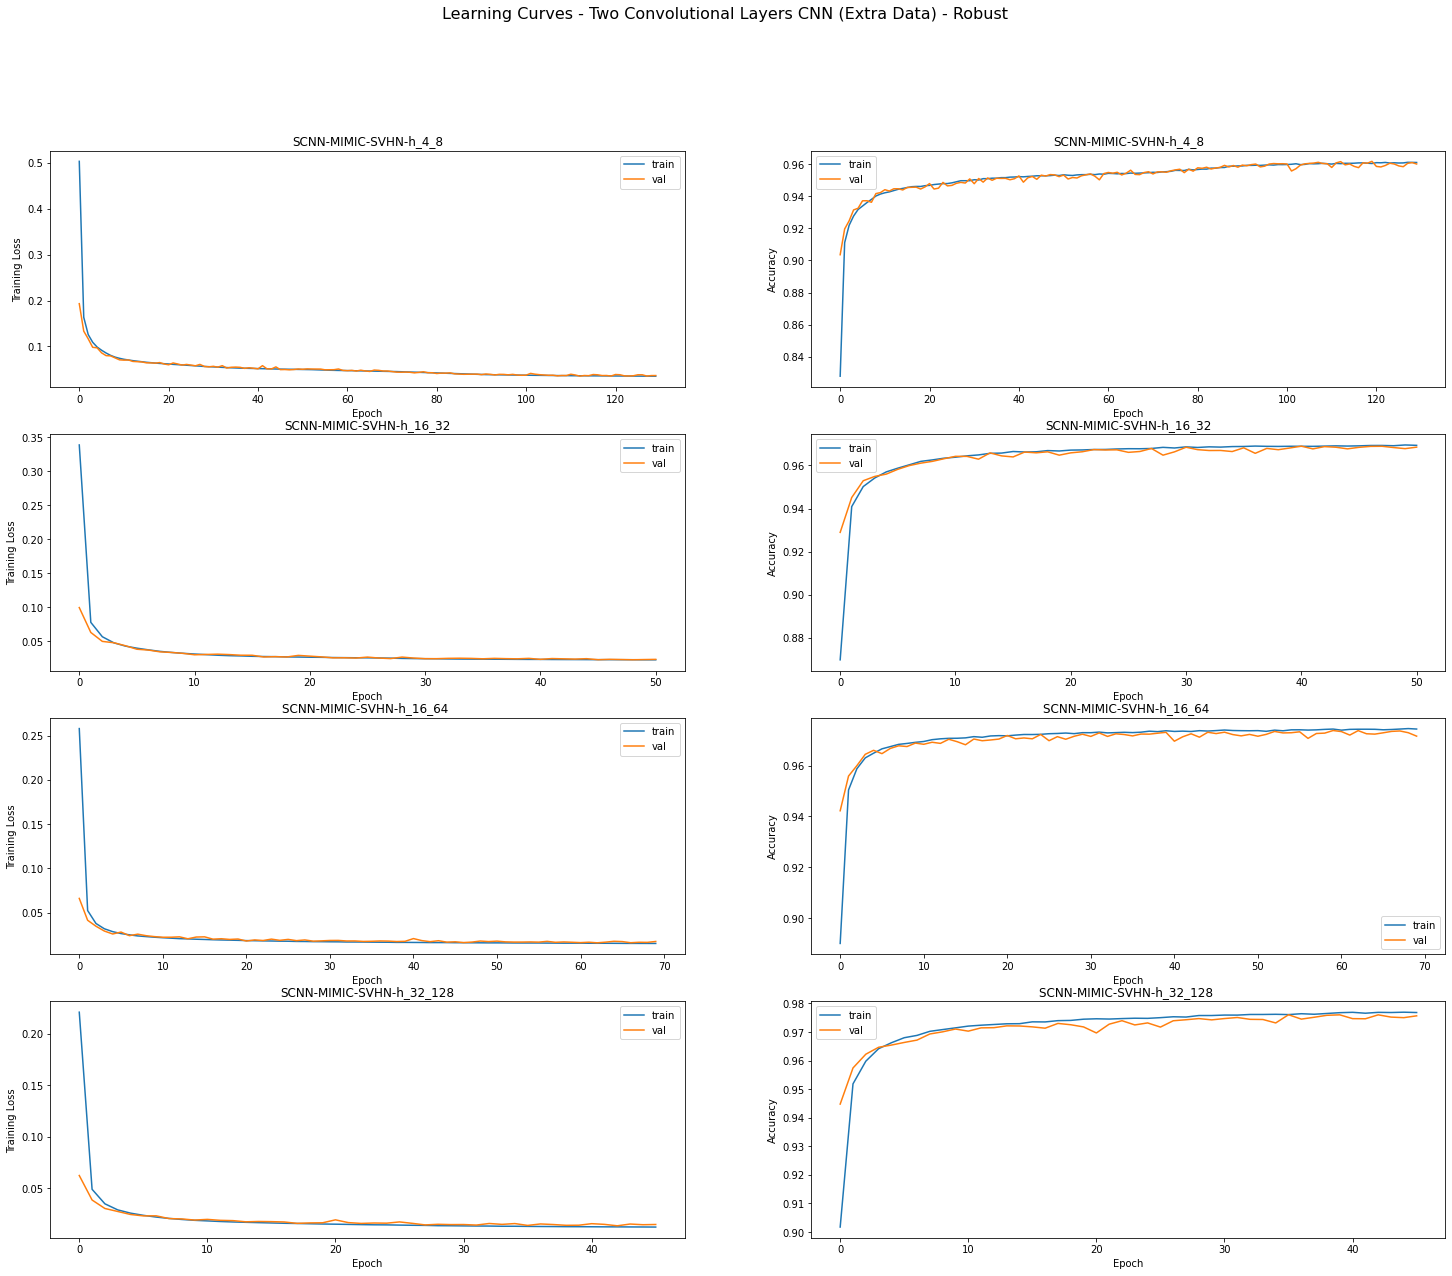

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Robust', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_4_8, label='train');
plt.plot(loss_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_4_8, label='train');
plt.plot(acc_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_16_32, label='train');
plt.plot(loss_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_16_32, label='train');
plt.plot(acc_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_16_64 , label='train');
plt.plot(loss_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_16_64 , label='train');
plt.plot(acc_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_32_128, label='train');
plt.plot(loss_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_32_128, label='train');
plt.plot(acc_test_32_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_32_128 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

## Teacher Temperature

In [ ]:
from scipy.special import softmax
def get_temperature_predictions (svhn_model, name, x_train, x_test, T):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('11').output)
  
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  # Devide with temperature
  train_logits_hard = train_logits_hard / T
  test_logits_hard = test_logits_hard / T

  # Pass it through softmax activation
  train_predictions = softmax(train_logits_hard, axis=1)
  test_predictions = softmax(test_logits_hard, axis=1)

  return train_predictions, test_predictions

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
import shutil

# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [4, 16, 16, 32] 
channels_to_test2 = [8, 32, 64, 128] 

index_for_two = 0;

temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for channel in channels_to_test:
  for t in temperatures:

    # Set name
    name = 'SCNN-SVHN-h'+ str(index_for_two)
    svhn_model = get_CNN_model()
    svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Robust_Keras.h5')

    train_predictions, test_predictions = get_temperature_predictions (svhn_model, name, x_train_cnn_extra, x_test_cnn_extra, t)
        
    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #Save trained SNN model
    svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_predictions, x_test_cnn_extra, test_predictions)

    # Learning Curves Data
    loss_train_cnn=svhn_model.history.history['loss']
    loss_val_cnn=svhn_model.history.history['val_loss']
    acc_train_cnn=svhn_model.history.history['accuracy']
    acc_val_cnn=svhn_model.history.history['val_accuracy']

    print ("")
    print (loss_train_cnn)
    print ("")
    print (loss_val_cnn)
    print ("")
    print (acc_train_cnn)
    print ("")
    print (acc_val_cnn)

    name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+str('_')+str(t)+'.h5'
    svhn_model.save(name_to_store)
    print ('Model: '+name_to_store+' was saved')

    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model = keras.models.load_model(name_to_store)

    score = 0;
    preds = svhn_model.predict(x_acc_test_cnn)
    for i in range (len(x_acc_test_cnn)):
      if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
        score = score + 1

    score=score/26032.0
    print ("Test Accuracy: %.5f" % score)
    scores_2_layer.append(score)
    channels_number.append(channel)

    shutil.move("/content/"+name_to_store, "/content/drive/My Drive/"+name_to_store)

    print ('----------------------------')

  index_for_two = index_for_two + 1
  print ('##############################')

## Adversarially Distillation

### Load Dataset to create Logit and Adversarial Examples

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
# Restore the labels
y_labels_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_train.npy')
y_labels_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_test.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')
y_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_train.npy')
y_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_test.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_acc_test.npy')

In [ ]:
def get_logits(svhn_model, x_train, x_test):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('11').output)
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  return train_logits_hard, test_logits_hard

In [ ]:
def adjust_model(svhn_model, name):

  # Normal probabilities from logits before softmax activation
  logits = svhn_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  svhn_model = Model(svhn_model.input, output, name=name)
  
  return svhn_model

In [ ]:
session = tf.Session()
session = tf.compat.v1.Session()
keras.backend.set_session(session)

In [ ]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import ProjectedGradientDescent

### Train Student - Initiallization

In [ ]:
# Initialliaze student models
channels_to_test = [4, 16, 16, 32] 
channels_to_test2 = [8, 32, 64, 128] 

index_for_two = 0;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  #Save trained SNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)

  score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
  print ("Test Accuracy: %.5f" % acc)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  index_for_two = index_for_two + 1

### Create the Logits for Target

In [ ]:
svhn_model = get_CNN_model()
#svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Robust_Keras.h5')
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras.h5')
train_logits, test_logits = get_logits(svhn_model, x_train_cnn_extra, x_test_cnn_extra)
svhn_model.add(layers.Activation('softmax'))

print(train_logits.shape)
print(test_logits.shape)

np.save('train_logits_base', train_logits)
np.save('test_logits_base', test_logits)

import shutil
shutil.move("/content/train_logits_base.npy", "/content/drive/My Drive/train_logits_base.npy")
shutil.move("/content/test_logits_base.npy", "/content/drive/My Drive/test_logits_base.npy")

### Create the Adversarial Examples based on Student

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=16, channels_l2=64)
svhn_model = keras.models.load_model('/content/student_h16_64.h5')

wrap = KerasModelWrapper(svhn_model)
pgd = ProjectedGradientDescent(wrap, sess=session)

epsilon = 0.01;

pgd_params = {'eps': epsilon,
              'eps_iter': epsilon / 5.0,
              'nb_iter': 100,
              'clip_min': 0.,
              'clip_max': 1.}
              
adv_x_test_cnn_extra_1 = pgd.generate_np(x_test_cnn_extra[0:100000], **pgd_params)
adv_x_test_cnn_extra_2 = pgd.generate_np(x_test_cnn_extra[100000:], **pgd_params)

adv_x_train_cnn_extra_1 = pgd.generate_np(x_train_cnn_extra[0:100000], **pgd_params)
adv_x_train_cnn_extra_2 = pgd.generate_np(x_train_cnn_extra[100000:200000], **pgd_params)
adv_x_train_cnn_extra_3 = pgd.generate_np(x_train_cnn_extra[200000:300000], **pgd_params)
adv_x_train_cnn_extra_4 = pgd.generate_np(x_train_cnn_extra[300000:400000], **pgd_params)
adv_x_train_cnn_extra_5 = pgd.generate_np(x_train_cnn_extra[400000:], **pgd_params)

adv_x_test_cnn_extra = np.concatenate((adv_x_test_cnn_extra_1, adv_x_test_cnn_extra_2), axis=0)

adv_x_train_cnn_extra = np.concatenate((adv_x_train_cnn_extra_1, adv_x_train_cnn_extra_2), axis=0)
adv_x_train_cnn_extra = np.concatenate((adv_x_train_cnn_extra, adv_x_train_cnn_extra_3), axis=0)
adv_x_train_cnn_extra = np.concatenate((adv_x_train_cnn_extra, adv_x_train_cnn_extra_4), axis=0)
adv_x_train_cnn_extra = np.concatenate((adv_x_train_cnn_extra, adv_x_train_cnn_extra_5), axis=0)
adv_x_train_cnn_extra = np.concatenate((adv_x_train_cnn_extra, adv_x_train_cnn_extra_6), axis=0)

print(adv_x_test_cnn_extra.shape)
print(adv_x_train_cnn_extra.shape)

np.save('adv_x_test_cnn_extra_16_64', adv_x_test_cnn_extra)
np.save('adv_x_train_cnn_extra_16_64', adv_x_train_cnn_extra)

import shutil
shutil.move("/content/adv_x_test_cnn_extra_16_64.npy", "/content/drive/My Drive/adv_x_test_cnn_extra_16_64.npy")
shutil.move("/content/adv_x_train_cnn_extra_16_64.npy", "/content/drive/My Drive/adv_x_train_cnn_extra_16_64.npy")

### Adversarial Distillation based on Student - Static

In [ ]:
adv_x_train_cnn_extra=np.load('/content/drive/My Drive/adv_x_train_cnn_extra_16_32.npy')
adv_x_test_cnn_extra=np.load('/content/drive/My Drive/adv_x_test_cnn_extra_16_32.npy')
train_logits=np.load('/content/drive/My Drive/train_logits_base.npy')
test_logits=np.load('/content/drive/My Drive/test_logits_base.npy')

print(adv_x_test_cnn_extra.shape)
print(adv_x_train_cnn_extra.shape)
print(train_logits.shape)
print(test_logits.shape)

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [4, 16, 16, 32] 
channels_to_test2 = [8, 32, 64, 128] 

channels_to_test = [16] 
channels_to_test2 = [32] 

index_for_two = 0;

epsilon = 0.01;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  #Save trained SNN model
  svhn_model = train_scnn(svhn_model, adv_x_train_cnn_extra, train_logits, adv_x_test_cnn_extra, test_logits)

  # Learning Curves Data
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_2_layer.append(score)
  channels_number.append(channel)

  index_for_two = index_for_two + 1

  print ('----------------------------')

### Adversarial Distillation based on Student - On-The-Fly

In [ ]:
adv_x_train_cnn_extra=np.load('/content/drive/My Drive/adv_x_train_cnn_extra_16_32.npy')
adv_x_test_cnn_extra=np.load('/content/drive/My Drive/adv_x_test_cnn_extra_16_32.npy')
train_logits=np.load('/content/drive/My Drive/train_logits_base.npy')
test_logits=np.load('/content/drive/My Drive/test_logits_base.npy')

print(adv_x_test_cnn_extra.shape)
print(adv_x_train_cnn_extra.shape)
print(train_logits.shape)
print(test_logits.shape)

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_labels_acc_test.npy')

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [4, 16, 16, 32] 
channels_to_test2 = [8, 32, 64, 128] 

index_for_two = 0;

epsilon = 0.01;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  accuracy_old = 0;
  accuracy_new = 100;
  first_time = True
  while accuracy_new > 0.60:
    first_time = False

    svhn_model.fit(adv_x_train_cnn_extra, train_logits, batch_size=128, epochs=1, verbose=0, validation_data=(adv_x_test_cnn_extra, test_logits))
    
    acc_val_cnn=svhn_model.history.history['val_accuracy']
    accuracy_old = accuracy_new
    accuracy_new = acc_val_cnn[-1]
    print (accuracy_new)

    output = svhn_model.layers[-1].output
    output = Activation('softmax')(output)
    svhn_model = Model(svhn_model.input, output, name=name)

    wrap = KerasModelWrapper(svhn_model)
    pgd = ProjectedGradientDescent(wrap, sess=session)
    epsilon = 0.01; 
    pgd_params = {'eps': epsilon,
              'eps_iter': epsilon / 5.0,
              'nb_iter': 20,
              'clip_min': 0.,
              'clip_max': 1.}

    adv_x_train_cnn_extra = pgd.generate_np(adv_x_train_cnn_extra, **pgd_params)
    adv_x_test_cnn_extra = pgd.generate_np(adv_x_test_cnn_extra, **pgd_params)

    svhn_model = adjust_model(svhn_model, name)
    svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)

  index_for_two = index_for_two + 1

  print ('----------------------------')

## Filter Pruning

In [ ]:
# Load the model
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')
svhn_model.summary()

In [ ]:
# Evaluate CNN
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, keras.utils.to_categorical(y_labels_acc_test, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
import matplotlib.pyplot as plt

svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')

w1 = svhn_model.layers[0].get_weights()[0]
w2 = svhn_model.layers[1].get_weights()[0]

conv_layers_weights = [w1,w2]

lists_weights = []

for i in range(len(conv_layers_weights)):
  weight = conv_layers_weights[i]
  weights_dict = {}
  num_filters = len(weight[0,0,0,:])

  for j in range(num_filters):
    w_s = np.sum(abs(weight[:,:,:,j]))
    filt = 'filt_{}'.format(j)
    weights_dict[filt] = w_s

  weights_dict_sort = sorted(weights_dict.items(), key=lambda kv: kv[1])
  print ('L1 norm conv layer {} \n'.format(i+1), weights_dict_sort)

  lists_weights.append(weights_dict_sort)

  weights_value = []
  for elem in weights_dict_sort:
    weights_value.append(elem[1])

  xc = range (num_filters)

  plt.figure(i+1, figsize=(7,5))
  plt.plot(xc, weights_value)
  plt.xlabel('filter_num')
  plt.ylabel('l1 norm')
  plt.title('conv layer {}'.format(i+1))
  plt.grid(True)

In [ ]:
!pip install kerassurgeon

In [ ]:
list_of_channels_to_remove_l2=[]

for item in lists_weights[1]:
  if (item[1] <= 70):
    new = item[0].split("_")
    list_of_channels_to_remove_l2.append(int(new[1]))

print (list_of_channels_to_remove_l2)

list_of_channels_to_remove_l1=[]

for item in lists_weights[0]:
  if (item[1] <= 3):
    new = item[0].split("_")
    list_of_channels_to_remove_l1.append(int(new[1]))

print (list_of_channels_to_remove_l1)

In [ ]:
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels, delete_layer

svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')

layer_1 = svhn_model.layers[0]
layer_2 = svhn_model.layers[1]

model_new = delete_channels(svhn_model, layer_2, list_of_channels_to_remove_l2)
model_new = delete_channels(model_new, layer_1, list_of_channels_to_remove_l1)

model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_new.save('SCNN_MIMIC_SVHN_h32_128_0.1_new_impr.h5')

model_new.summary()

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1_new_impr.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, keras.utils.to_categorical(y_labels_acc_test, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)